In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import glob
import numpy as np
import stephane.display.graphes as graphes
#import stephane.elasticity.processing as proc
import fluids2d.backlight as bl
import pims
import lea.danjruth.piv as piv
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import stephane.cine.cine as cine
import stephane.tools.Smath as Smath
import scipy.interpolate as interp
import sys

import stephane.analysis.cdata as cdata

import lea.hdf5.h5py_convert as h5pylea
import lea.data.Data as ldata

import lea.mesure.Mesure as mesure
#import lea.mesure.Volume as lvolume
#import lea.mesure.Piv3D as lpiv3d

In [3]:
date = '20181106'
savefolder = '/Users/stephane/Documents/JRC_ENS/Experimental_data/Turbulence3d/'+date+'/'
folder = savefolder

In [4]:
ext = '.hdf5'
l=glob.glob(folder+'*'+ext)
for i,name in enumerate(l):
    print(str(i)+' : '+os.path.basename(name))

s = input()
try:
    i = int(s)
except:
    print("cannot be converted to an integer")

mesurefile = l[i]

0 : 20181106_2_PIV3d_nikon50mm_64pumps_random16_fps40k_Pump30Hz_f1kHz_A1600mV_line5.hdf5
1 : 20181106_3_PIV3d_nikon50mm_64pumps_random16_fps40k_Pump30Hz_f1kHz_A1600mV_line5_z450mm.hdf5
2 : 20181106_4_PIV3d_nikon50mm_64pumps_random16_fps40k_Pump30Hz_f800Hz_A1600mV_line5_z400mm.hdf5
3 : 20181106_5_PIV3d_nikon50mm_64pumps_random16_fps40k_Pump30Hz_f800Hz_A1600mV_line5_z400mm_EXPT2.hdf5
4 : Mesure_0_20181106_4_PIV3d_nikon50mm_64pumps_random16_fps40k_Pump30Hz_f800Hz_A1600mV_line5_z400mm.hdf5
4


In [5]:
mesurefile

'/Users/stephane/Documents/JRC_ENS/Experimental_data/Turbulence3d/20181106/Mesure_0_20181106_4_PIV3d_nikon50mm_64pumps_random16_fps40k_Pump30Hz_f800Hz_A1600mV_line5_z400mm.hdf5'

In [5]:
f = h5pylea.ouverture_fichier(mesurefile)
M = h5pylea.h5py_in_Mesure(f)
f.close()#ouvrir un data à partir d'un hdf5 existant

{}


In [78]:
M.PIV3D.m['U'].shape

(101560, 23, 63, 2)

In [8]:
nz = 40
int(M.PIV3D.data.fps/M.PIV3D.data.f)
print(nz)

40


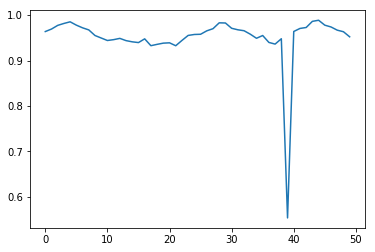

In [6]:
# rough spatial correlation to get the end positions of the laser
data = M.PIV3D.m['U']
C=[]
for i in range(50):
    d0 = np.nanmean(data[i,...,0])
    d1 = np.nanmean(data[i+1,...,0])
    s0 = np.nanstd(data[i,...,0])
    s1 = np.nanstd(data[i+1,...,0])
    C.append(np.nanmean((data[i,...,0]-d0)*(data[i+1,...,0]-d1))/(s0*s1))
plt.plot(C)

i0 = 6;

In [9]:
#cut volumes by hand
(N,nx,ny,nc) = data.shape
nt = int((N-i0)//nz)
print(nt)
print(i0+nt*nz)

dreshape = np.zeros((nt,nz//2,nx,ny,nc))
for i in range(nt):
    dreshape[i,...] = data[i0+i*nz:i0+i*nz+nz//2,...]
print(dreshape.shape)

2538
101526
(2538, 20, 23, 63, 2)


In [78]:
#print(data.shape)
#data = np.transpose(data,(1,0,2,3,4))
#print(data.shape)

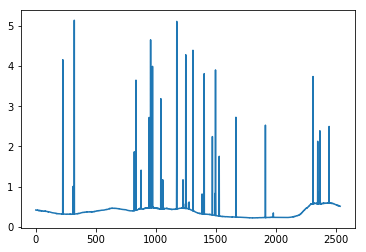

In [10]:
# Energy plot
E = []
for i in range(nt):
    E.append(np.nanstd(dreshape[i,...]**2))
plt.plot(E)

In [19]:
from mpl_toolkits import mplot3d

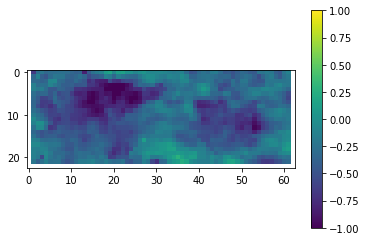

In [16]:
plt.figure(1)
j=10
for i in range(0,2000,20):
    plt.cla()
    plt.imshow(dreshape[i,j,...,0],vmin=-1,vmax=1)
    if i==0:
        plt.colorbar()
    filename = savefolder + 'Results/Movies/'+'2dplane_center/z'+str(j)+'_t'+str(i)
    graphes.save_fig(1,filename,frmt='png',dpi=100,overwrite=False)

In [21]:
dreshape.shape
(nt,nz,ny,nx,nc)= dreshape.shape
print(dreshape.shape)

(2538, 20, 21, 61, 2)


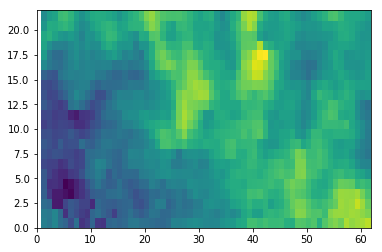

In [85]:
#dreshape = np.transpose(dreshape,(0,1,3,2,4))                       
x = np.arange(0,nx)
y = np.arange(0,ny)
[X,Y] = np.meshgrid(x,y)
plt.pcolormesh(X,Y,dreshape[10,10,...,0])

In [11]:
dreshape = dreshape[:,:,1:-1,1:-1,:]

960

In [27]:
M.PIV3D.data.dx = M.PIV3D.data.fx*16
M.PIV3D.data.dy = M.PIV3D.data.dx
print(M.PIV3D.data.dx)
print(nz)
M.PIV3D.data.dz = M.PIV3D.data.l_c/nz
print(M.PIV3D.data.dz)
dx = M.PIV3D.data.dx

4.432
20
2.2


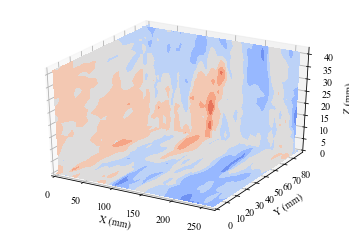

In [218]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

(dx,dy,dz)= (M.PIV3D.data.dx,M.PIV3D.data.dy,M.PIV3D.data.dz)
(nt,nz,ny,nx,nc)=dreshape.shape

levels = np.linspace(-1.5,1.5,10)
fig = plt.figure(1)
ax = fig.gca(projection='3d')
        
c=1
for i in range(0,2500,1000):
    plt.cla()
#ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
    x = dx*np.arange(0,nx)
    y = dy*np.arange(0,ny)
    [X,Y] = np.meshgrid(x,y)
    cset = ax.contourf(X,Y,dreshape[i,1,...,c],levels,zdir='z',offset=0,cmap=cm.coolwarm)#,offset =-100,cmap=cm.coolwarm)

    x = dx*np.arange(0,nx)
    z = dz*np.arange(0,nz)
    [X,Z] = np.meshgrid(x,z)
    cset = ax.contourf(X,dreshape[i,:,ny-1,:,c],Z,levels,zdir='y',offset=np.max(y)-dy,cmap=cm.coolwarm)#,offset =-100,cmap=cm.coolwarm)

    y = dy*np.arange(0,ny)
    z = dz*np.arange(0,nz)
    [Y,Z] = np.meshgrid(y,z)
    cset = ax.contourf(dreshape[i,:,:,0,c],Y,Z,levels,zdir='x',offset=dx,cmap=cm.coolwarm)#,offset =-100,cmap=cm.coolwarm)

#    if i==0:
#        ax.colorbar()
#z = np.arange(0,nz//2)
#x = np.arange(0,nx)
#[Z,X] = np.meshgrid(z,x)
#cset = ax.contourf(Z,np.transpose(dreshape[10,:,1,:,0]),X,zdir='y',offset=nx,cmap=cm.coolwarm)#,offset =-100,cmap=cm.coolwarm)


#contour(X, Y, Z, zdir='z', offset=-100, cmap=cm.coolwarm)
#cset = ax.contour(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
#cset = ax.contour(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)

    ax.set_xlabel('X (mm)')
    ax.set_xlim(0, dx*(nx-1))
    ax.set_ylabel('Y (mm)')
    ax.set_ylim(0, dy*(ny-1))
    ax.set_zlabel('Z (mm)')
    ax.set_zlim(0, dz*(nz-1))

    filename = savefolder + 'Results/Movies/'+'3d_faces_ux/_t'+str(i)
#    graphes.save_fig(1,filename,frmt='png',dpi=100,overwrite=False)

#plt.show()


1.0
81


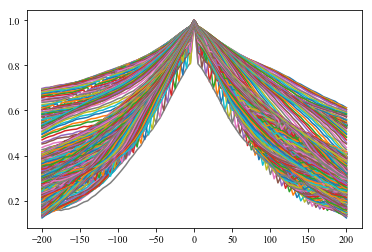

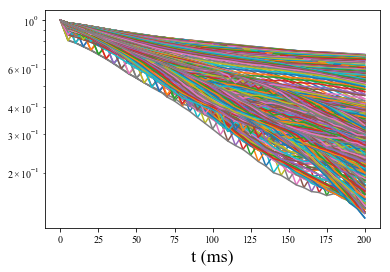

In [219]:
c=0
ndt = 200;
ft = 1000/(M.PIV3D.data.fps/(2*nz))
print(ft)


indices = range(ndt,nt-ndt,ndt//40)
dindices = range(-ndt,ndt+ndt//40,ndt//40)

n = len(dindices)
print(n)
t = np.linspace(-ndt*ft,ndt*ft,n)

tau = []
for i0 in indices:
    E0 = np.nanmean(dreshape[i0,...,c])
    S0 = np.nanstd(dreshape[i0,...,c])

    C=[]
    for i in dindices:
        Ei = np.nanmean(dreshape[i+i0,...,c])
        Si = np.nanstd(dreshape[i+i0,...,c])
        C.append(np.nanmean((dreshape[i+i0,...,c]-Ei)*(dreshape[i0,...,c]-E0))/(S0*Si))
    
    plt.figure(1)
    plt.plot(t,C)
    
    plt.figure(2)
    plt.semilogy(np.abs(t),C)
    
    p = np.polyfit(np.abs(t), np.log(C), 1)
    tau.append(-1/p[0])
fig = graphes.legende('t (ms)','','')

In [12]:
# to be imported from 
import stephane.analysis.cdata as cdata

def nancount(data):
    print(data.shape)
    Nnan = np.sum(np.ndarray.flatten(np.isnan(data)))
    N = np.prod(data.shape)
    print('Ratio nan :' +str(Nnan/N))
    print('nan number :'+str(Nnan))
### CHarge un fichier Data## .
### CHarge un fichier Data## .

        

def remove_nan_3d(ff):
    #Fields with d components along the last axis
    Nc = ff.shape[-1]
    Nt = ff.shape[0]
    for i in range(Nt):
        for j in range(Nc):
            data = np.squeeze(ff[i,...,j])
            indices = np.where(np.isnan(data))
            #adapted to 3d data
            (t0,t1,t2) = indices
            for tup in zip(t0,t1,t2):
                data = cdata.replace_nan(data,tup)
            ff[i,...,j]=data
    return ff

def remove_aberrant(ff,bound=5):
    #Fields with d components along the last axis
    Nt = ff.shape[0]
    Nc = ff.shape[-1]
    for i in range(Nt):
        for c in range(Nc):
            data = np.squeeze(ff[i,...,c])
            M0 = np.nanmean(data)
            S0 = np.nanstd(data)
            indices = np.where(np.abs(data-M0)>bound*S0)
                #adapted to 3d data
            (t0,t1,t2) = indices
            for tup in zip(t0,t1,t2):
                data = cdata.replace_nan(data,tup)
            ff[i,...,c]=data
    return ff


751


In [230]:
n/np.prod(dreshape.shape)

6.875200312009985e-05

In [13]:
nancount(dreshape)
dreshape = remove_nan_3d(dreshape)
nancount(dreshape)

(2538, 20, 21, 61, 2)
Ratio nan :1.9408349835044405e-05
nan number :2524
(2538, 20, 21, 61, 2)
Ratio nan :0.0
nan number :0


[-8, 8, 1e-08, 10]

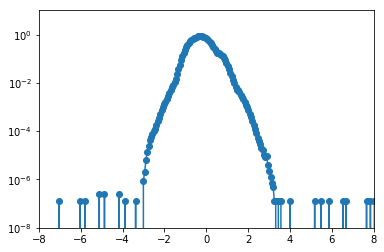

In [14]:
x = graphes.hist(np.ndarray.flatten(dreshape),num=10**3,log=True)
plt.axis([-8,8,10**-8,10**1])

0.34409643038775567 0.07115748340825495


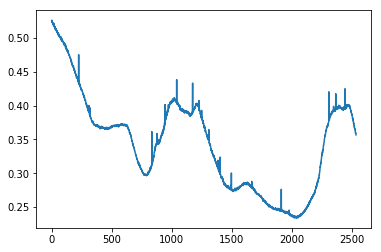

In [15]:
c=0
E = [np.nanstd(dreshape[i,...,c]) for i in range(nt)]
plt.plot(E)
print(np.nanmean(E),np.nanstd(E))

In [16]:
dreshape = remove_aberrant(dreshape)

0.34343078937207305 0.07097008208101017


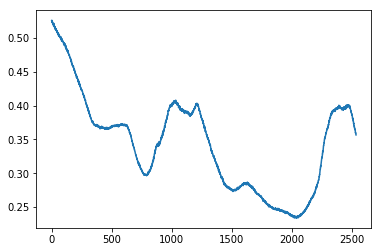

In [17]:
c=0
E = [np.nanstd(dreshape[i,...,c]) for i in range(nt)]
plt.plot(E)
print(np.nanmean(E),np.nanstd(E))

(2, 2538)
0.34343078937207305 0.07097008208101017


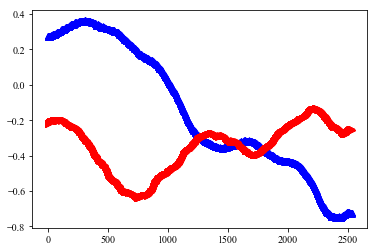

In [344]:
c=1
Up = np.asarray([[np.nanstd(dreshape[i,...,c])**2 for i in range(nt)] for c in range(2)])
Umoy = np.asarray([[np.nanmean(dreshape[i,...,c]) for i in range(nt)] for c in range(2)])

print(np.asarray(Umoy).shape)
#plt.plot(Up[0,:],'ro-')
#plt.plot(Up[1,:],'bo-')
plt.plot(Umoy[0,:],'b^-')
plt.plot(Umoy[1,:],'r>-')
print(np.nanmean(E),np.nanstd(E))

[-8, 8, 1e-08, 10]

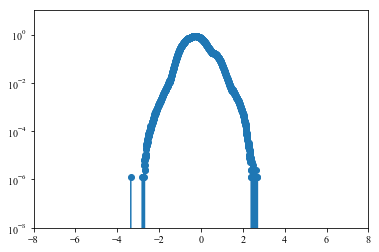

In [243]:
x = graphes.hist(np.ndarray.flatten(dreshape),num=10**3,log=True)
plt.axis([-8,8,10**-8,10**1])

In [22]:
dimensions = dreshape.shape
fluc = np.zeros(dimensions)
for i in range(nt):
    for c in range(2):
        M0 = np.nanmean(dreshape[i,...,c])
        fluc[i,...,c] = dreshape[i,...,c]-M0

In [254]:
fluc.shape

(2538, 20, 21, 61, 2)

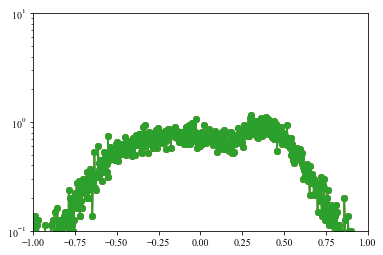

In [724]:
i0 = 200
c=0 
bound =1
x = graphes.hist(np.ndarray.flatten(fluc[i0,...,c]),num=10**3,log=True)

x = graphes.hist(np.ndarray.flatten(fluc[i0,...,c]),num=10**3,log=True)

x = graphes.hist(np.ndarray.flatten(fluc[i0,...,c]),num=10**3,log=True)
plt.axis([-bound,bound,10**-1,10**1])
fig = graphes.legende('','','')

[ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46
 48]
[   0    1  100  101  200  201  300  301  400  401  500  501  600  601
  700  701  800  801  900  901 1000 1001 1100 1101 1200 1201 1300 1301
 1400 1401 1500 1501 1600 1601 1700 1701 1800 1801 1900 1901 2000 2001
 2100 2101 2200 2201 2300 2301 2400 2401]
(25, 20, 21, 61)
(25, 20, 21, 61)


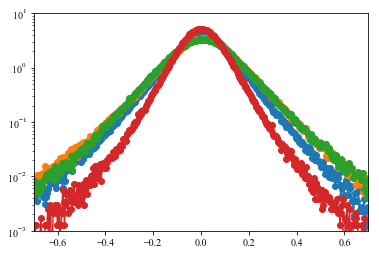

In [757]:
i0 = 200
c=0 
bound =0.7
indices = [i for i in np.arange(0,nt-101,100)]
indicesp1 = [i+1 for i in np.arange(0,nt-101,100)]

tindices = indices+indicesp1
tindices = np.sort(tindices)

part = np.arange(0,len(tindices),2)
print(part)
print(tindices)

print(fluc[indices,...,c].shape)
x1,n1 = graphes.hist(np.ndarray.flatten(np.diff(fluc[indices,...,c],axis=3)),num=10**3,log=True)

x2,n2 = graphes.hist(np.ndarray.flatten(np.diff(fluc[indices,...,c],axis=2)),num=10**3,log=True)

x3,n3 = graphes.hist(1.1*np.ndarray.flatten(np.diff(fluc[indices,...,c],axis=1)),num=10**3,log=True)

acc = np.diff(fluc[tindices,...,c],axis=0)[part,...]
print(acc.shape)
x = graphes.hist(np.ndarray.flatten(acc),num=10**3,log=True)
#x = graphes.hist(np.ndarray.flatten(fluc[i0,3:,...,c]-fluc[i0,0:-3,...,c]),num=10**3,log=True)
plt.axis([-bound,bound,10**-3,10**1])
fig = graphes.legende('','','')

#distribution of acceleration and velocity gradients along each direction. 3 dimensions of space consistent, 
# acceleration pdf has a different shape


In [165]:
fx = M.PIV3D.data.fx

In [157]:
np.std(dreshape[0,...,0])

0.5261845498107248

In [28]:
c=0
indices = [i for i in np.arange(0,nt-101,10)]
up = np.std(fluc[indices,...,c])
Dx = dx/1000.
dudx = np.std(np.diff(fluc[indices,...,c]/Dx,axis=3))
dudy = np.std(np.diff(fluc[indices,...,c]/Dx,axis=2))
dudz = np.std(np.diff(fluc[indices,...,c]/Dx,axis=1))

lx_taylor = up/dudx #l_taylor in m
ly_taylor = up/dudy #l_taylor in m
lz_taylor = up/dudz #l_taylor in m

print(dudx,dudy,dudz)
print(lx_taylor,ly_taylor,lz_taylor) # l_taylor in mm

29.159961520734814 34.168776888416545 30.904822494301925
0.011979833558449034 0.010223704721125305 0.011303461964668766


In [849]:
l_taylor = up/dudx #l_taylor in m
print(l_taylor*10**3) # l_taylor in mm
# Taylor scale around 1cm ... is it reasonnable ?

11.033099785336946


In [155]:
l_taylor = 0.006

In [166]:
nu = 10**-6
epsilon_nu = 15*nu*up**2/l_taylor**2*fx**2
print(epsilon_nu)

0.003901429450631016


0.012184308422617782

In [876]:
du.shape

(244, 20, 21, 60)

[  4.432   8.864  13.296  17.728  22.16   26.592  31.024  35.456  39.888
  44.32   48.752  53.184  57.616  62.048  66.48   70.912  75.344  79.776
  84.208  88.64   93.072  97.504 101.936 106.368 110.8   115.232 119.664
 124.096 128.528 132.96  137.392 141.824 146.256 150.688 155.12  159.552
 163.984 168.416 172.848 177.28  181.712 186.144 190.576 195.008 199.44
 203.872 208.304 212.736 217.168]


[0, 30, -0.5, 1]

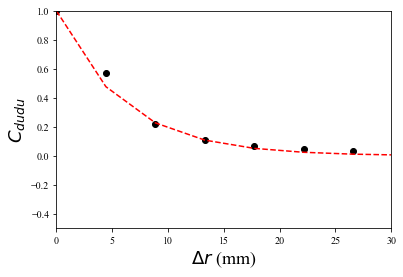

In [904]:
# spatial correlation of velocity gradients : "kind of" exponential, but badly define : long range correlation
c=1
indices = [i for i in np.arange(0,nt-101,10)]
du = np.diff(fluc[indices,...,c]/Dx,axis=2)
Cdu=[1]
n=2
deltax = np.arange(50)*dx
print(deltax[1:])
for i,dx0 in enumerate(deltax):
    if i>0:
        m0 = np.mean(du[...,i:])
        s0 = np.std(du[...,i:])
    
        m1 = np.mean(du[...,0:-i])
        s1 = np.std(du[...,0:-i])
    
        s =np.nanmean((du[...,i:]-m0)*(du[...,0:-i]-m1))/(s0*s1)
        Cdu.append(s)
plt.plot(deltax,Cdu,'ko')
plt.plot(deltax,np.exp(-deltax/1000*2/l_taylor),'r--')
fig = graphes.legende(r'$\Delta r$ (mm)',r'$C_{dudu}$','')
plt.axis([0,30,-0.5,1])

#factor 2 in the definition of l_taylor (??) quite weird

#this is spatial correlation of eulerian acceleration !

In [902]:
for c in range(2):
    up = np.std(fluc[indices,...,c])
    print(up)

0.3493314855891815
0.43307942266059724


[  4.432   8.864  13.296  17.728  22.16   26.592  31.024  35.456  39.888
  44.32   48.752  53.184  57.616  62.048  66.48   70.912  75.344  79.776
  84.208  88.64   93.072  97.504 101.936 106.368]


[0, 100, -0.1, 1]

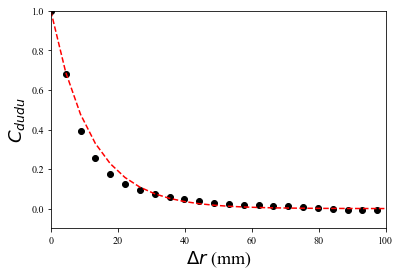

In [913]:
# spatial correlation of velocity gradients : "kind of" exponential, but badly define : long range correlation
c=0
indices = [i for i in np.arange(0,nt-101,10)]
du = np.diff(fluc[indices,...,c]/Dx,axis=2)
Cdu=[1]
n=2
deltax = np.arange(25)*dx
print(deltax[1:])
for i,dx0 in enumerate(deltax):
    if i>0:
        m0 = np.mean(du[...,i:])
        s0 = np.std(du[...,i:])
    
        m1 = np.mean(du[...,0:-i])
        s1 = np.std(du[...,0:-i])
    
        s =np.nanmean((du[...,i:]-m0)*(du[...,0:-i]-m1))/(s0*s1)
        Cdu.append(s)
plt.plot(deltax,Cdu,'ko')
plt.plot(deltax,np.exp(-deltax/1000/l_taylor),'r--')
fig = graphes.legende(r'$\Delta r$ (mm)',r'$C_{dudu}$','')
plt.axis([0,100,-0.1,1])

In [941]:
tup=(1,2,3)

2

In [940]:
a = [[i+j for i in range(3)] for j in range(4)]
a = np.asarray(a)

z = slice(1,2)
a[(slice(3),slice(1,3))]

array([[1, 2],
       [2, 3],
       [3, 4]])

TypeError: C_dudu_dx() got an unexpected keyword argument 'display'

In [50]:
# spatial correlation of velocity gradients : "kind of" exponential, but badly define : long range correlation
def C_dudu_dx(fluc,c=0,dx_dir=0,dr=0,display=False,dx=1):
    indices = [i for i in np.arange(0,nt-101,10)]
    
    du = np.diff(fluc[indices,...,c],axis=dx_dir+1)
    Cdu=[1]

    deltax = np.arange(20)*dx
    
    dim = du.shape
    tup0 = [slice(dim[0]),slice(dim[1]),slice(dim[2]),slice(dim[3])]
    tup1 = [slice(dim[0]),slice(dim[1]),slice(dim[2]),slice(dim[3])]
    
    for i,dx0 in enumerate(deltax):
        if i>0:
            # we compute the correlation along the dr direction in space
            tup0[dr+1] = slice(i,dim[dr+1])
            tup1[dr+1] = slice(0,dim[dr+1]-i)
                
            m0 = np.mean(du[tuple(tup0)])
            s0 = np.std(du[tuple(tup0)])
    
            m1 = np.mean(du[tuple(tup1)])
            s1 = np.std(du[tuple(tup1)])
    
            s =np.nanmean((du[tuple(tup0)]-m0)*(du[tuple(tup1)]-m1))/(s0*s1)
            Cdu.append(s)
            
    p = np.polyfit(deltax[:3],np.log(Cdu[:3]),deg=1)
    l0 = -1./p[0]
    print(l0)
    if display:
        plt.plot(deltax,Cdu,'ko')
        plt.plot(deltax,np.exp(-deltax/l0),'r--')
        fig = graphes.legende(r'$\Delta r$ (mm)',r'$C_{dudu}$','')
        plt.axis([0,100,-0.1,1])
        
    return Cdu,l0
#symetrical, but the correlation of du
# let consider the 2d component (u,v) along (x,y)
# we compute 
# C_dududx(Dy), C_dvdvdx(Dy), C_dvdvdy(Dx), C_dududy(Dx) 
# The "double transverse" have correlation length twice bigger than the "single transverse",
# ie, depend on the relative orientation of du,dy
#c=1 is along y, c=0 is along x
#for dUdUdx_dy, specific for c=1, ie c=1 correspond to x, c=0 correspond to y

5.500610020613914


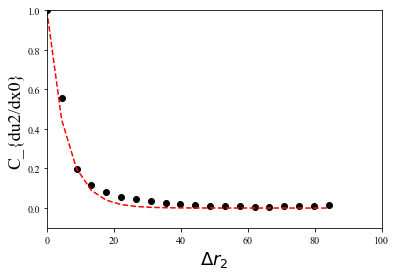

In [49]:
(i,j,k) = (1,0,2)
a = C_dudu_dx(fluc,c=i,dx_dir=j,dr=k,display=True,dx=dx)
fig = graphes.legende(r'$\Delta r_{'+str(k)+'}$','C_{du'+str(i+1)+'/dx'+str(j)+'}','')


4.779835919832266
5.570917304318622
10.562774627248055
9.513875724310576
7.1979250300963535
5.423171607138912
6.375215999718971
5.500610020613914
7.512856461258403
5.796145348414776
11.21153736238755
10.36759505550608


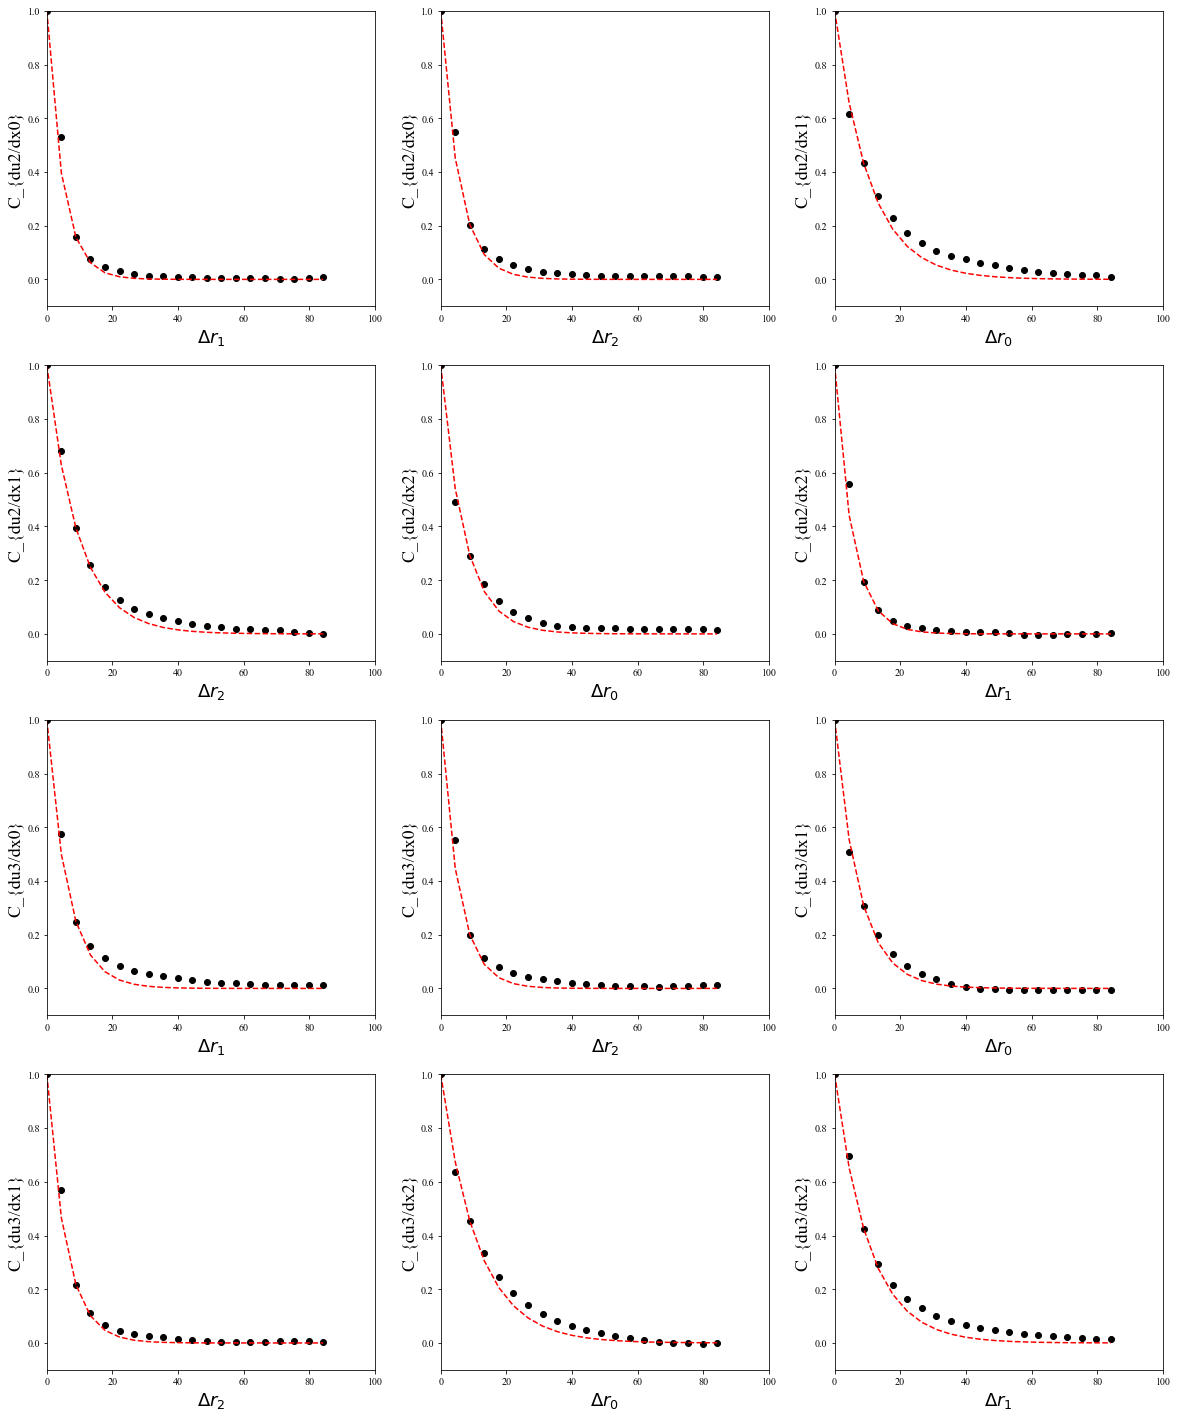

In [59]:
fig,axs=plt.subplots(4,3,figsize=(20,25))

count = 0
L = np.zeros((3,3,3))
for i in range(1,3):
    for j in range(3):
        for k in range(3):
            if not k==j:
                count = count+1
                plt.subplot(4,3,count)
                C,l0 = C_dudu_dx(fluc,c=i-1,dx_dir=j,dr=k,display=True,dx=dx)
                L[i,j,k] = l0
                graphes.legende(r'$\Delta r_{'+str(k)+'}$','C_{du'+str(i+1)+'/dx'+str(j)+'}','')

In [60]:
print(L[:,:,0])
print(L[:,:,1])
print(L[:,:,2])
#all taylor length, Tensor representation of the form
#T_ijk = C[dui/dxj(Drk)]
# elements k=j are ill defined, the velocity gradients along the same direction are negatively correlated (?)
# elements i=0 have not been computed
# elemnts i=j corresponds to longitudinal velocity gradients, the correlation length is roughly twice bigger
# from the tensor, we can confirm c=0 corresponds to y and c=1 corresponds to x direction.


[[ 0.          0.          0.        ]
 [ 0.         10.56277463  7.19792503]
 [ 0.          7.51285646 11.21153736]]
[[ 0.          0.          0.        ]
 [ 4.77983592  0.          5.42317161]
 [ 6.375216    0.         10.36759506]]
[[0.         0.         0.        ]
 [5.5709173  9.51387572 0.        ]
 [5.50061002 5.79614535 0.        ]]


[ 4.432  8.864 13.296 17.728 22.16  26.592 31.024 35.456 39.888 44.32
 48.752 53.184 57.616 62.048 66.48  70.912 75.344 79.776 84.208]


NameError: name 'l_taylor' is not defined

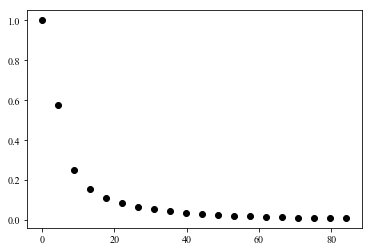

In [97]:
# spatial correlation of velocity gradients : "kind of" exponential, but badly define : long range correlation
c=1
indices = [i for i in np.arange(0,nt-101,10)]
du = np.diff(fluc[indices,...,c]/Dx,axis=1)
Cdu=[1]
n=2
deltax = np.arange(20)*dx
print(deltax[1:])
for i,dx0 in enumerate(deltax):
    if i>0:
        m0 = np.mean(du[...,i:,:])
        s0 = np.std(du[...,i:,:])
    
        m1 = np.mean(du[...,0:-i,:])
        s1 = np.std(du[...,0:-i,:])
    
        s =np.nanmean((du[...,i:,:]-m0)*(du[...,0:-i,:]-m1))/(s0*s1)
        Cdu.append(s)
plt.plot(deltax,Cdu,'ko')
plt.plot(deltax,np.exp(-deltax/1000*2/l_taylor),'r--')
fig = graphes.legende(r'$\Delta r$ (mm)',r'$C_{dudu}$','')
plt.axis([0,100,-0.1,1])

#symetrical, but the correlation of du
# let consider the 2d component (u,v) along (x,y)
# we compute 
# C_dududx(Dy), C_dvdvdx(Dy), C_dvdvdy(Dx), C_dududy(Dx) 
# The "double transverse" have correlation length twice bigger than the "single transverse",
# ie, depend on the relative orientation of du,dy
#c=1 is along y, c=0 is along x
#for dUdUdx_dy, specific for c=1, ie c=1 correspond to x, c=0 correspond to y

[0, 25, -0.5, 1]

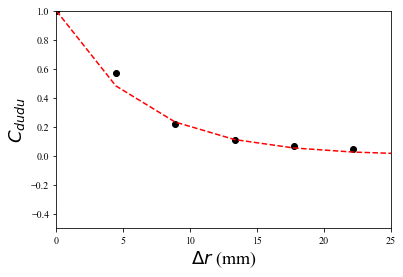

In [884]:
plt.plot(deltax,Cdu,'ko')
plt.plot(deltax,np.exp(-deltax/1000/l_taylor*2),'r--')
fig = graphes.legende(r'$\Delta r$ (mm)',r'$C_{dudu}$','')
plt.axis([0,25,-0.5,1])

In [98]:
# second order velocity increment
#longitudinal structure function
c=0
S2=[]
n=2
for i in range(1,50):
    if np.mod(i,10)==0:
        print(i)
    s =np.nanmean((fluc[...,i:,c] - fluc[...,0:-i,c])**n)
    S2.append(s)

10
20
30
40


0.5439282932204211


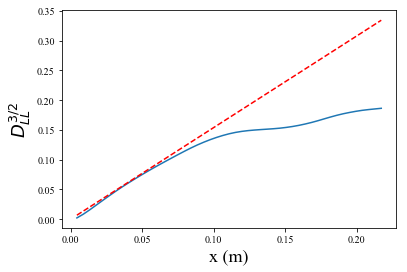

In [139]:
# second order velocity increment representation
S2 = np.asarray(S2)
x=np.arange(1,50)*dx/1000
plt.plot(x,S2**(3/2))
a = 0.1/65*10**3
epsilon = a/2**(1.5) # in mm^2/s^{-3}
print(epsilon)
plt.plot(x,a*x,'r--')
#plt.axis([0,220,0,0.25])
fig = graphes.legende('x (m)',r'$D_{LL}^{3/2}$','')

In [106]:
# second order velocity increment
#transverse structure function 
c=1
S2_x1=[]
n=2
for i in range(1,50):
    if np.mod(i,10)==0:
        print(i)
    s =np.nanmean((fluc[...,i:,c] - fluc[...,0:-i,c])**n)
    S2_x1.append(s)

10
20
30
40


0.5439282932204211


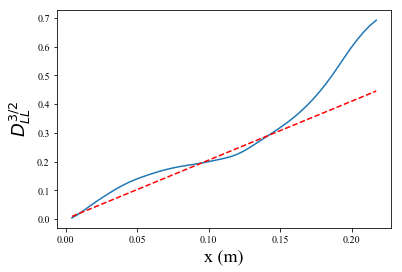

In [130]:
# second order velocity increment representation
S2_x1 = np.asarray(S2_x1)
x=np.arange(1,50)*dx/1000
plt.plot(x,S2_x1**(3/2))
a = 0.1/65*10**3
epsilon = a/2**(1.5) # in mm^2/s^{-3}
print(epsilon)
plt.plot(x,a*x*4/3,'r--')
#plt.axis([0,220,0,0.25])
fig = graphes.legende('x (m)',r'$D_{LL}^{3/2}$','')

In [122]:
# third order velocity increment : be careful ! we need i=k to compute it, otherwise it goes to 0
# i = k = 2 (c=0)
c=0
S3_x0=[]
n=3
for i in range(1,50):
    if np.mod(i,10)==0:
        print(i)
    dUn = (dreshape[...,i:,c] - dreshape[...,0:-i,c])**n
    s =np.nanmean(dUn)
    S3_x0.append(s)

10
20
30
40


0.5439282932204211


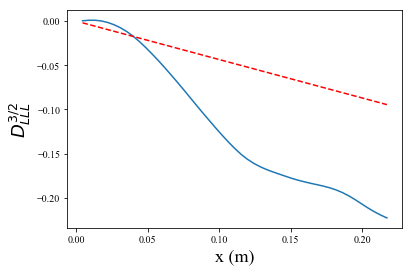

In [131]:
# third order velocity increment representation: 
# we expect the third moment to be 
S3_x0 = np.asarray(S3_x0)
x=np.arange(1,len(S3_x0)+1)*dx/1000
plt.plot(x,-S3_x0)
print(epsilon) #epsilon should then be equal to 3 ?
# strange : the flux increases a lot for d > 10cm. It should go the opposite and almost vanishes for that distance ?
# explanation ?

plt.plot(x,-epsilon*4/5*x,'r--')
#plt.axis([0,220,0,0.25])
fig = graphes.legende('x (m)',r'$D_{LLL}^{3/2}$','')


In [113]:
# third order velocity increment : be careful ! we need i=k to compute it, otherwise it goes to 0
# we check i=k=1, (c=0) 

c=1
S3_y1=[]
n=3
for i in range(1,20):
    if np.mod(i,10)==0:
        print(i)
    dUn = (dreshape[...,i:,:,c] - dreshape[...,0:-i,:,c])**n
    s =np.nanmean(dUn)
    S3_y1.append(s)

10


0.5439282932204211


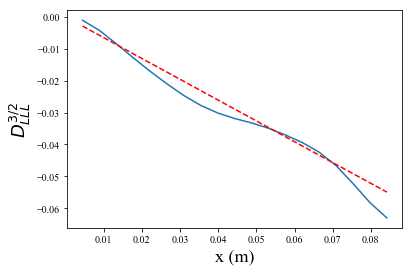

In [138]:
# third order velocity increment representation: 
# we expect the third moment to be 
S3_y1 = np.asarray(S3_y1)
x=np.arange(1,len(S3_y1)+1)*dx/1000
plt.plot(x,-S3_y1)
print(epsilon) #epsilon should then be equal to 3 ?
# strange : the flux increases a lot for d > 10cm. It should go the opposite and almost vanishes for that distance ?
# explanation ?

plt.plot(x,-epsilon*1.5*x*4/5,'r--')
#plt.axis([0,0.08,0,0.05])
fig = graphes.legende('x (m)',r'$D_{LLL}^{3/2}$','')

#along y, the third law is not verified ! #worse : it tends to have energy transfer toward large scale along y
# would the turbulence be strongly anisotropic ? Not at small scales, but it may at large scales ...
# to be evaluated

0.5439282932204211


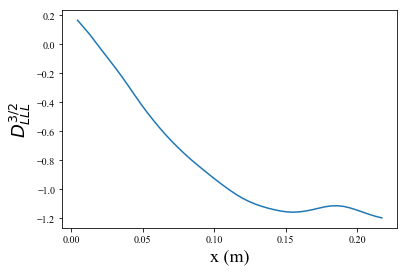

In [145]:
# third order velocity increment representation: 
# we expect the third moment to be 
#S3_y1 = np.asarray(S3_y1)
x=np.arange(1,len(S2)+1)*dx/1000
plt.plot(x,-S3_x0/S2**(3./2))
print(epsilon) #epsilon should then be equal to 3 ?
# strange : the flux increases a lot for d > 10cm. It should go the opposite and almost vanishes for that distance ?
# explanation ?

#plt.plot(x,-epsilon*1.5*x*4/5,'r--')
#plt.axis([0,0.08,0,0.05])
fig = graphes.legende('x (m)',r'$D_{LLL}^{3/2}$','')

#along y, the third law is not verified ! #worse : it tends to have energy transfer toward large scale along y
# would the turbulence be strongly anisotropic ? Not at small scales, but it may at large scales ...
# to be evaluated

In [87]:
# third order velocity increment : be careful ! we need i=k to compute it, otherwise it goes to 0
# i = k = 2 (c=1)
c=0
S3x2r1=[]
n=3
for i in range(1,50):
    if np.mod(i,10)==0:
        print(i)
    dUn = (dreshape[...,i:,c] - dreshape[...,0:-i,c])**n
    s =np.nanmean(dUn)
    S3x2r1.append(s)

10
20
30
40


3.076923076923077


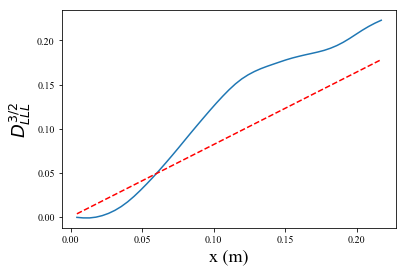

In [90]:
# third order velocity increment representation: 
# we expect the third moment to be 
S3 = np.asarray(S3x2r1)
x=np.arange(1,len(S3x2r1)+1)*dx/1000
plt.plot(x,S3x2r1)
print(epsilon) #epsilon should then be equal to 3 ?
# strange : the flux increases a lot for d > 10cm. It should go the opposite and almost vanishes for that distance ?
# explanation ?

plt.plot(x,epsilon*4/5*x/3,'r--')
#plt.axis([0,220,0,0.25])
fig = graphes.legende('x (m)',r'$D_{LLL}^{3/2}$','')

In [80]:
# third order velocity increment : be careful ! we need i=k to compute it, otherwise it goes to 0
# we look at i=2 (c=1) and k=1

c=1
S3uy=[]
n=3
for i in range(1,20):
    if np.mod(i,10)==0:
        print(i)
    dUn = (dreshape[...,i:,:,c] - dreshape[...,0:-i,:,c])**n
    s =np.nanmean(dUn)
    S3uy.append(s)

10


3.076923076923077


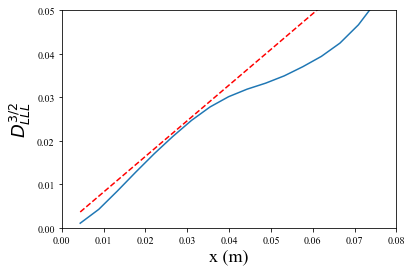

In [85]:
# third order velocity increment representation: 
# be careful we have here i ≠ k, not sure it make any sense.
S3uy = np.asarray(S3uy)
x=np.arange(1,len(S3uy)+1)*dx/1000
plt.plot(x,S3uy)
print(epsilon) #epsilon should then be equal to 3 ?
# strange : the flux increases a lot for d > 10cm. It should go the opposite and almost vanishes for that distance ?
# explanation ?

plt.plot(x,epsilon*4/5*x/3,'r--') # about a third goes toward the large scale ...
plt.axis([0,0.08,0,0.05])
fig = graphes.legende('x (m)',r'$D_{LLL}^{3/2}$','')
#it seems that the large scales, although in appearence isotropic 
#(u' ~ v' ~ w', all taylor scales equivalent, integral length scales comparable)
# the energy flux seems to be very anisotropic.
# the flux define from the slope of <(dui_drj)^3> 
#gives 
# second order goes like r^(2/3) for all directions
# third order :
#<(du2_dr2)^3> = - 4/5 epsilon r
#<(du1_dr1)^3> = 0 at small scale, get bigger at large scale
#<(du1_dr2)^3> = -1/3 <(du2_dr2)^3> at all scales
#<(du2_dr1)^3> = 0, then -1/3 <(du2_dr2)^3> at large scales
# what about the other ones ?
# we expect : 
#<(du0_dr0)^3> = - 4/5 epsilon r
#<(du0_dr1,2)^3> = 0, then -1/3 <(du2_dr2)^3> at large scales ?
#<(dru2_dr0)^3 > =  0, then -1/3 <(du2_dr2)^3> at large scales ?
#[...]

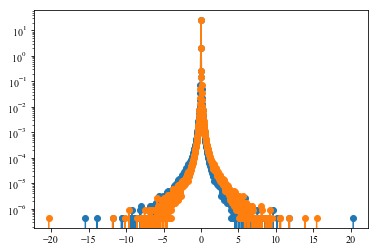

In [373]:
x = graphes.hist(np.ndarray.flatten(dUn),num=10**3,log=True)
x = graphes.hist(np.ndarray.flatten(-dUn),num=10**3,log=True)
#plt.axis([-0.001,0.001,10**1,10**4])

#print(np.mean(dUn**3))

In [335]:
c=1
S3 = np.ndarray.tolist(S3)
#S3=[]
n=3
for i in range(50,61):
    if np.mod(i,10)==0:
        print(i)
    s =np.nanmean((dreshape[...,i:,c] - dreshape[...,0:-i,c])**n)
    S3.append(s)

50
60


NameError: name 'S' is not defined

0.5


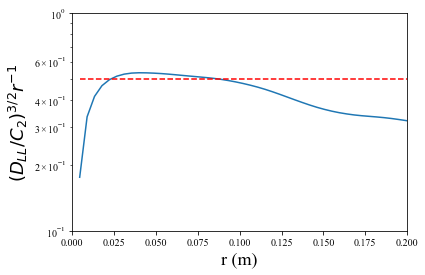

In [407]:
# compensated second order velocity increment. The plateau gives a measurement of epsilon in the inertial range. 
# it decreases slightly at large r, but not that much.
# third order moment ? -> badly determined unfortunately
S = np.asarray(S)
x=np.arange(1,50)*dx/1000
C2 = 2
plt.semilogy(x,(S/C2)**1.5/x)
a = 0.1/65*10**3
epsilon = 0.5 # in mm^2/s^{-3}
print(epsilon)
plt.plot(x,np.zeros(49)+epsilon,'r--')
plt.axis([0,0.2,10**-1,10**0])
fig = graphes.legende('r (m)',r'$(D_{LL}/C_2)^{3/2}r^{-1}$','')

In [383]:
#correlation function : exponential decay with l ~ 5 cm
c=1
CxxN=[]
for i in range(60):
    if np.mod(i,10)==0:
        print(i)
    if i==0:
        CxxN.append(1)
    else:
        dC = (fluc[...,i:,c]*fluc[...,0:-i,c])/(np.std(fluc[...,0:-i,c])*(np.std(fluc[...,0:-i,c])))    
        CxxN.append(np.mean(dC))  
        
c=0
CxxL=[]
for i in range(60):
    if np.mod(i,10)==0:
        print(i)
    if i==0:
        CxxL.append(1)
    else:
        dC = (fluc[...,i:,c]*fluc[...,0:-i,c])/(np.std(fluc[...,0:-i,c])*(np.std(fluc[...,0:-i,c])))    
        CxxL.append(np.mean(dC))                                                                                  

0
10
20
30
40
50


[0, 0.2, -0.3, 1]

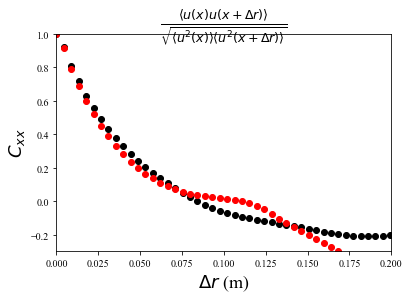

In [712]:
x=np.arange(len(Cxx))*dx/1000
plt.plot(x,Cxx,'ko')
plt.plot(x,CxxN,'ro')
fig = graphes.legende(r'$\Delta r$ (m)',r'$C_{xx}$',r'$\frac{\langle u(x) u(x+\Delta r) \rangle}{\sqrt{\langle u^2(x)\rangle \langle u^2(x+\Delta r) \rangle}}$')

plt.axis([0,0.2,-0.3,1])


In [774]:
# correlation function in time and in space i0 = 200
c=1
dtlist = [0,5,10,50,100]
dxlist = [0,1,2,5]

ndt = len(dtlist)
ndx = len(dxlist)
Cxt=np.zeros((ndx,ndt))

# we compute along x

for j,Dt in enumerate(dtlist):
    print(j)
    for i,Dx in enumerate(dxlist):
        print('   '+str(i))
        if Dt==0 and Dx==0:
            u0 = fluc[...,c]
            u1 = u0
        elif Dx==0:
            u0 = fluc[Dt:,...,c]
            u1 = fluc[0:-Dt,...,c]
        elif Dt==0:
            u0 = fluc[...,Dx:,c]
            u1 = fluc[...,0:-Dx,c]
        else:
            u0 = fluc[Dt:,...,Dx:,c]
            u1 = fluc[0:-Dt,...,0:-Dx,c]
        dC = (u0*u1)/(np.std(u0)*np.std(u1))  
        Cxt[i,j]= np.mean(dC)
        

#distribution of acceleration and velocity gradients along each direction. 3 dimensions of space consistent, 
# acceleration pdf has a different shape


0
   0
   1
   2
   3
1
   0
   1
   2
   3
2
   0
   1
   2
   3
3
   0
   1
   2
   3
4
   0
   1
   2
   3


25.38

In [836]:
c=1 
FT_t = np.mean(np.abs(np.fft.fft(dreshape[...,c]**2,axis=0)),axis=(1,2,3))

[1, 1000, 1, 1000]

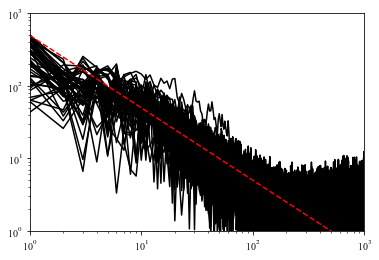

In [835]:
(k0,j0,i0) = (10,10,30)
c=1
for k0 in range(3,16,2):
    for j0 in range(3,16,2):
        FT_t_ext = np.abs(np.fft.fft(dreshape[:,k0,j0,i0,c]**2,axis=0))

        plt.loglog(FT_t_ext[:nt//2],'k-')
E0 = 50
f0 = 10
plt.loglog(f,E0*(f/f0)**(-1),'r--')
plt.axis([1,10**3,1,10**3])

2538
2538


[1, 1000, 1, 1000]

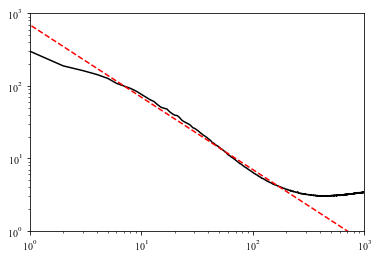

In [838]:
print(len(FT_t))
print(nt)
fe = 10**3
f = np.arange(1,len(FT_t[:nt//2])+1)*2*fe/nt
plt.loglog(FT_t[:nt//2],'k-')

E0 = 7*10
f0 = 10
plt.loglog(f,E0*(f/f0)**(-1),'r--')
plt.axis([1,10**3,1,10**3])

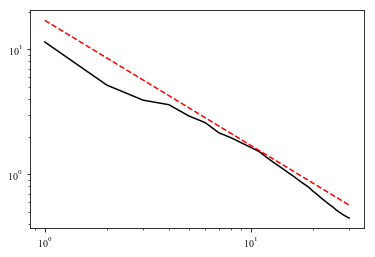

In [834]:
#FT_x = np.mean(np.abs(np.fft.fft(fluc[...,c]**2,axis=3)),axis=(0,1,2))

kx = np.arange(1,len(FT_x[:nx//2])+1)
plt.loglog(kx,FT_x[:nx//2],'k-')

E0 = 1.7
k0 = 10
plt.loglog(kx,E0*(kx/k0)**(-1),'r--')
# polluted by noise at small scale ...

[[1.         0.9702695  0.95630202 0.81731294 0.67539736]
 [0.93222221 0.9177676  0.90753861 0.79112324 0.65446835]
 [0.82023956 0.81649348 0.81156697 0.73934214 0.62150676]
 [0.55473921 0.55240218 0.54995425 0.5271912  0.48212   ]]


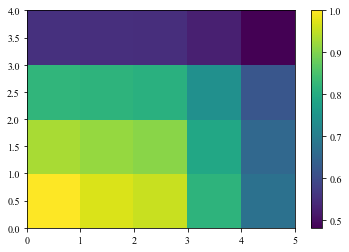

In [791]:

print(Cxt)
plt.pcolormesh(Cxt)
plt.colorbar()

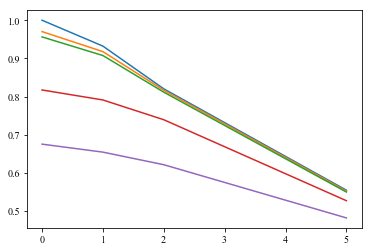

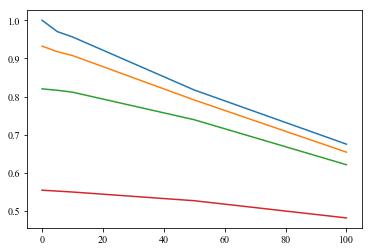

In [792]:
plt.figure(1)
plt.plot(dxlist,Cxt)

plt.figure(2)
plt.plot(dtlist,np.transpose(Cxt))

-1.0

1.0
50
101
0.1382860488525509
0.03507304165495727
0.11767370332419295
0.03035507052554361
0.016532137058508947
(5, 101)


[-50, 50, -0.03, 0.03]

<Figure size 432x288 with 0 Axes>

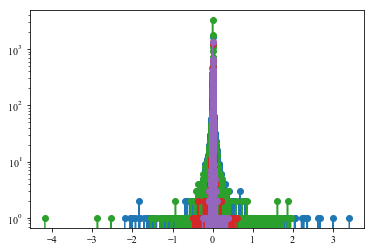

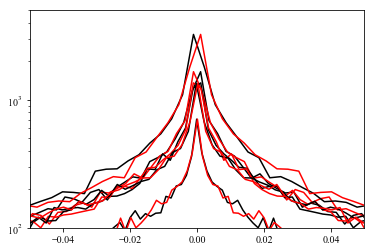

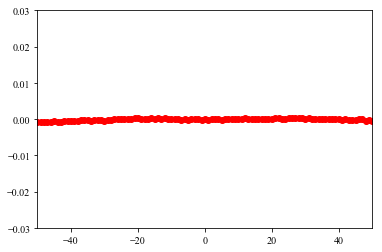

In [678]:
# Test de l'irréversibilité

c=0
ndt = 50;
ft = 1000/(M.PIV3D.data.fps/(2*nz))
print(ft)

print(ndt)
indices = range(ndt,nt-ndt,ndt*10)
dindices = range(-ndt,ndt+1,1)

n = len(dindices)
print(n)
t = np.linspace(-ndt*ft,ndt*ft,n)

tau = []
Psi = []
for i0 in indices:
    E0 = np.nanmean(dreshape[i0,...,c])
    S0 = np.nanstd(dreshape[i0,...,c])

    psi=[]
    
    u0 = dreshape[i0,...,c]-E0#-Umoy[...,c]
    for i in dindices:
        Ei = np.nanmean(dreshape[i+i0,...,c])
        Si = np.nanstd(dreshape[i+i0,...,c])
        
        ui = dreshape[i+i0,...,c]-Ei#-Umoy[...,c]
        psi_pdf = (u0**2*ui-ui**2*u0)
        if i==49:
            plt.figure(3)
            print(np.nanstd(psi_pdf))
            xbin,n = graphes.hist(np.ndarray.flatten(psi_pdf),num=10**4,log=True,normalize=False)
            
            plt.figure(4)
            sx = np.sqrt(np.mean(xbin**2*n))
            plt.semilogy(xbin/sx,n,'k')
            plt.semilogy(-xbin/sx,n,'r')

        psi.append(np.nanmean(u0**2*ui)-np.nanmean(ui**2*u0))
        
    Psi.append(psi)

plt.axis([-0.05,0.05,10**2,5*10**3])

Psi = np.asarray(Psi)

#plt.figure(3)
#xbin,n = graphes.hist(np.ndarray.flatten(Psi),num=10**5,log=True,normalize=False)

#    plt.figure(1)
#    plt.plot(t,psi,'k-')


print(Psi.shape)
Psimoy = np.nanmean(Psi,axis=0)

plt.figure(5)
plt.plot(t,Psimoy,'ro-')
plt.axis([-ndt,ndt,-0.03,0.03])
#    plt.figure(2)
#    plt.semilogy(np.abs(t),psi)
    
#p = np.polyfit(np.abs(t), np.log(psi), 1)
#tau.append(-1/p[0])
#fig = graphes.legende('t (ms)',r'$\psi$','')


[-0.5, 0.5, 1000, 10000000]

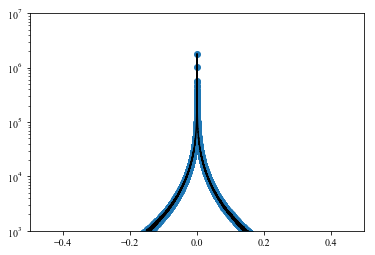

In [642]:
xbin,n = graphes.hist(np.ndarray.flatten(Psi),num=10**6,log=True,normalize=False)

plt.semilogy(xbin,n,'k')
plt.semilogy(-xbin,n,'r')
plt.axis([-0.5,0.5,10**3,10**7])

[-0.2, 0.2, 1000, 10000000]

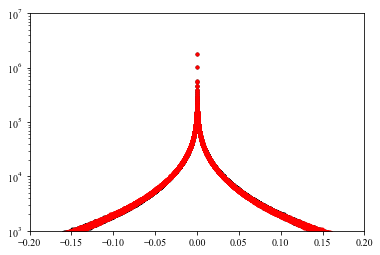

In [645]:
plt.semilogy(xbin,n,'k.')
plt.semilogy(-xbin,n,'r.')
plt.axis([-0.2,0.2,10**3,10**7])

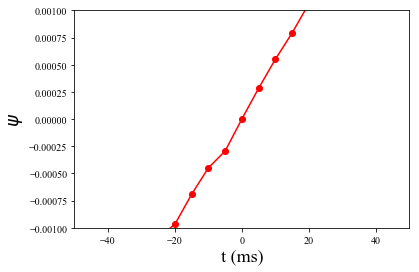

In [633]:

plt.figure(1)
plt.plot(t,Psimoy,'ro-')
plt.axis([-50,50,-0.001,0.001])
#    plt.figure(2)
#    plt.semilogy(np.abs(t),psi)
    
#p = np.polyfit(np.abs(t), np.log(psi), 1)
#tau.append(-1/p[0])
fig = graphes.legende('t (ms)',r'$\psi$','')

In [679]:
gamma.shape

(2536, 20, 21, 61)

<Figure size 432x288 with 0 Axes>

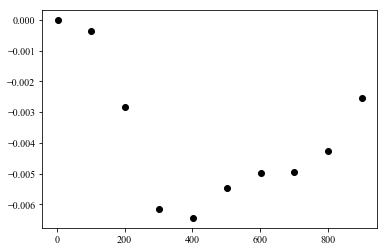

In [709]:
# Distribution des accélérations * u^2
#-> la quantité annoncée est peu fiable, globalement de moyenne nulle par rapport à son écart type. 
# difficile à distinguer du bruit

c=1
Asym = []
Sasym = []
tau = range(2,1000,100)

display = False
for i0 in tau:
    plt.figure(1)
    c=0
    gamma = dreshape[i0:,...,c]-dreshape[0:-i0,...,c]
    
    gamma0 = np.mean(gamma)
    E0 = np.mean(dreshape[i0//2:-i0//2,...,c])
    Y = (gamma-gamma0)*(dreshape[i0//2:-i0//2,...,c]-E0)**2
    
    if display:
        xbin,n = graphes.hist(Y,num=2*10**5,log=False,normalize=False)
        plt.axis([10**-4,0.2,0,13*10**3])

        plt.semilogy(xbin,n)
        plt.semilogy(-xbin,n,'r')
        plt.axis([-0.2,0.2,10,10**6])
    Asym.append(np.mean(Y))
    Sasym.append(np.std(Y))

Asym = np.asarray(Asym)
Sasym = np.asarray(Sasym)

plt.figure(2)
plt.plot(tau,Asym,'ko')
#plt.plot(tau,Asym+Sasym,'k--')
#plt.plot(tau,Asym-Sasym,'k--')



In [697]:
print(np.mean(gamma))
print(np.std(gamma))
print(np.mean(dreshape))

-0.08504603081130756
0.38685763816435653
0.30242160709109245


[1e-05, 0.1, 100, 13000.0]

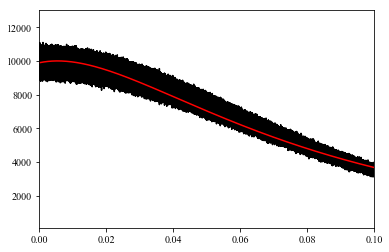

In [532]:
# fit de la distribution d'accélérations
plt.plot(xbin,n,'k')
P0 = 10**4
gamma0 = 0.055
a = 0.9
plt.plot(xbin,P0*np.exp(-(np.log((xbin+a*gamma0)/gamma0))**2),'r.-')
plt.axis([10**-5, 10**-1,10**2,1.3*10**4,])

plt.plot(xbin,P0/(1+),'b.-')
plt.axis([10**-5, 10**-1,10**2,1.3*10**4,])


[0.01, 1, 500, 13000.0]

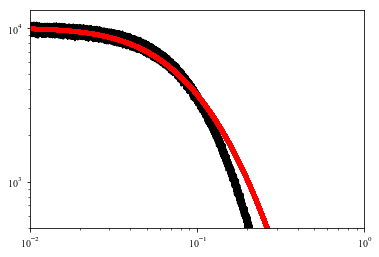

In [620]:
# fit de la distribution d'accélérations
plt.loglog(xbin,n,'k')
P0 = 10**4
gamma0 = 0.055
a = 0.9
plt.loglog(xbin,P0*np.exp(-(np.log((xbin+a*gamma0)/gamma0))**2),'r.-')
plt.axis([10**-5, 10**-1,10**2,1.3*10**4,])

#plt.loglog(xbin,P0/(1+),'b.-')
plt.axis([10**-2, 1,5*10**2,1.3*10**4,])


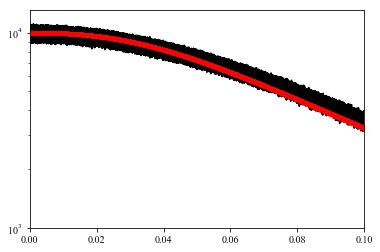

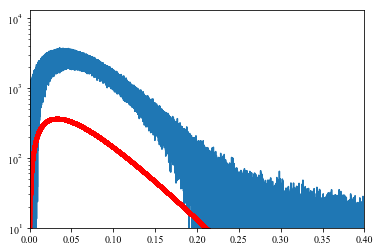

In [613]:
# fit de la distribution d'accélérations
plt.semilogy(xbin,n,'k')
P0 = 10**4
gamma0 = 0.055
a = 0.9
#plt.plot(xbin,P0*np.exp(-(np.log((xbin+a*gamma0)/gamma0))**2),'r.-')
plt.axis([0,0.1,10**3,1.3*10**4])

x0 = 0.07
denom = x0*(x0**2+xbin**2)
a = 0.25
y = P0*np.exp(-(a*x0*xbin**2+xbin**3)/denom)

plt.plot(xbin,y,'r.-')

x0 = 0.065
denom = x0*(x0**2+xbin**2)
a = 0.25
y = P0*np.exp(-xbin/x0) 

z0 = 6.5*10**3
x1 = x0/2
alpha = 1.

yf = y + P0*(xbin/x1)**alpha*np.exp(-(xbin/x1))

#plt.plot(xbin,yf,'b.-')

plt.figure(2)
plt.semilogy(xbin,n-y)

plt.axis([0,0.4,10**1,1.3*10**4])


z = P0/10*(xbin/x1)**alpha*np.exp(-xbin/x1)
plt.semilogy(xbin,z,'r.-')
#plt.plot(xbin,P0/(1+),'b.-')
#plt.axis([10**-5, 10**-1,10**2,1.3*10**4,])


[-500, 500, -0.03, 0.03]

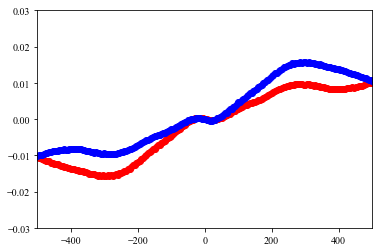

In [453]:
plt.figure(1)
plt.plot(t,Psimoy,'ro-')
plt.plot(-t,-Psimoy,'bo-')
plt.axis([-ndt,ndt,-0.03,0.03])

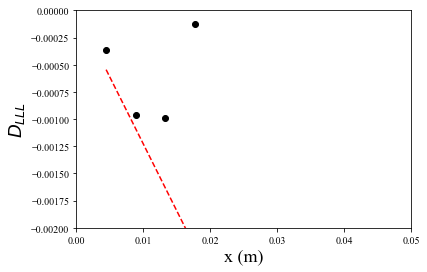

In [352]:
S3 = np.asarray(S3)
x=np.arange(1,len(S3)+1)*dx/1000
plt.plot(x,S3,'ko')
b = -epsilon*(4/5)
plt.plot(x,b*x,'r--')
#a = 0.1/65
#plt.plot(x,a*x,'r--')
plt.axis([0,0.05,-0.002,0])
fig = graphes.legende('x (m)',r'$D_{LLL}$','')

(array([36., 68., 76., 37., 71., 32., 14., 16.,  1.,  2.,  2.,  2.,  1.,
         3.,  1.,  2.,  3.,  4.,  4.,  4.,  6.,  3.,  2.,  3.,  4.,  8.,
         8.,  4.,  4.,  7.]),
 array([118.14136189, 129.97306681, 141.80477173, 153.63647665,
        165.46818156, 177.29988648, 189.1315914 , 200.96329631,
        212.79500123, 224.62670615, 236.45841107, 248.29011598,
        260.1218209 , 271.95352582, 283.78523074, 295.61693565,
        307.44864057, 319.28034549, 331.11205041, 342.94375532,
        354.77546024, 366.60716516, 378.43887008, 390.27057499,
        402.10227991, 413.93398483, 425.76568975, 437.59739466,
        449.42909958, 461.2608045 , 473.09250942]),
 <a list of 30 Patch objects>)

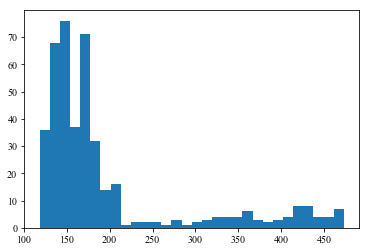

In [181]:
plt.figure(3)
plt.hist(np.asarray(tau),30)
#x = graphes.hist(-1/np.asarray(tau),num=30,log=True,normalize=True)

In [196]:
np.median(tau) # "very large" tail -> sometime the velocity field get correlated on a much longer time scale
L = np.nanmedian(tau)*np.nanmean(E)/1000
print(L) #correlation length computed from L ~ u' t_c, where u' = u_rms and t_c : mean correlation time of u'
# à comparer avec L_L ~ 5 cm de T. Jamin

0.056759284799246634


In [42]:
M.PIV3D.m['U'] = M.PIV3D.m['np']
M.PIV3D.m.pop('np')

array([[[[            nan,             nan],
         [-9.51807022e-01, -4.06265259e-03],
         [-7.79851913e-01, -7.37953186e-02],
         ...,
         [ 6.48654938e-01,  1.02441788e+00],
         [ 6.04118347e-01,  1.02114296e+00],
         [            nan,             nan]],

        [[            nan,             nan],
         [-7.92375565e-01,  1.20380402e-01],
         [-6.20676041e-01,  1.66206360e-01],
         ...,
         [ 5.01815796e-01,  1.01694107e+00],
         [ 5.63861847e-01,  1.01125145e+00],
         [            nan,             nan]],

        [[            nan,             nan],
         [-2.96548843e-01,  2.29539871e-01],
         [-2.55971909e-01,  1.96941376e-01],
         ...,
         [ 3.31470490e-01,  8.77960205e-01],
         [ 2.47882843e-01,  8.41100693e-01],
         [            nan,             nan]],

        ...,

        [[            nan,             nan],
         [ 4.51164246e-02,  2.92079926e-01],
         [-1.49684906e-01, -7.92808533

In [43]:
print(M.PIV3D.m['U'].shape)
ff = M.PIV3D.m['U']

(127397, 23, 63, 2)


In [47]:
M.data.param.startV = int(M.data.param.startV)
M.data.param.endV = int(M.data.param.endV)

In [50]:
 #convert 2d to 3d data
(Nt,Nx,Ny,Nc) = ff.shape
frame_diff = M.data.param.fps // M.data.param.f
print(frame_diff)
Nt = Nt//frame_diff
Nz = frame_diff

ff = np.reshape(ff[:Nt*Nz,...],(Nt,Nz,Nx,Ny,Nc))
ff[...,1] = -ff[...,1] #reverse sign of horizontal component
start = M.data.param.startV
end = M.data.param.endV
#ff=ff[:,9:25,...]
#(start,end) = v.m['instantV'][0]
ff=ff[:,start+2:end-2,...]
print(ff.shape)

40
(3184, 16, 23, 63, 2)


In [ ]:
piv = M.PIV3D

In [59]:
piv.data.param.l_c = float(piv.data.param.l_c)

In [60]:
piv.data.param.fx

0.277

In [61]:
dz = float(piv.data.param.l_c)/frame_diff*2
print(dz)

piv.m['overlap'] = 16
dx = piv.data.param.fx*piv.m['overlap']
print(dx)

#generate axis
(Nz,Nx,Ny,Nc) = mean_flow.shape
#mean_flow = np.transpose(mean_flow,(1,2,0,3))

x = np.arange(-(Nx-1)/2,(Nx-1)/2+1)*dx
y = np.arange(-(Ny-1)/2,(Ny-1)/2+1)*dx
z = np.arange(-Nz/2,Nz/2)*dz-2

#invariance by rotation in the plane (x,z)

[X,Z,Y] = np.meshgrid(x,z,y)
print(X.shape)

2.2
4.432


In [66]:
#generate space axis
piv.m['x'] = x
piv.m['y'] = y
piv.m['z'] = z

In [67]:
piv.data.param.fps

40000

In [70]:
piv.m['U'].shape

(3184, 16, 21, 61, 2)

In [72]:
#generate time axis
ft = frame_diff/piv.data.param.fps
print(ft)
piv.m['ft'] =  ft
piv.m['t'] = np.arange(0,Nt*ft,ft)
piv.m['t'].shape

0.001


(3184,)

In [51]:
def nancount(data):
    print(data.shape)
    Nnan = np.sum(np.ndarray.flatten(np.isnan(data)))
    N = np.prod(data.shape)
    print('Ratio nan :' +str(Nnan/N))
    print('nan number :'+str(Nnan))

In [52]:
nancount(ff)
ff = ff[...,1:-1,1:-1,:]
nancount(ff)

(3184, 16, 23, 63, 2)
Ratio nan :0.07385668313097579
nan number :10903884
(3184, 16, 21, 61, 2)
Ratio nan :2.9896138577352023e-05
nan number :3902


In [53]:
Nt = ff.shape[0]
for i in range(Nt):
    for j in range(2):
        data = np.squeeze(ff[i,...,j])
        indices = np.where(np.isnan(data))
        (t0,t1,t2) = indices
        for tup in zip(t0,t1,t2):
            data = cdata.replace_nan(data,tup)
        ff[i,...,j]=data
nancount(ff)

(3184, 16, 21, 61, 2)
Ratio nan :0.0
nan number :0


In [63]:
piv.m['U'] = ff
piv.m.pop('fluc')

array([[[[[-1.00859649e+00, -8.53744086e-02],
          [-8.96077916e-01,  1.71344326e-01],
          [-1.04690249e+00,  2.37501622e-01],
          ...,
          [ 5.22969578e-02,  4.35724658e-01],
          [-7.53773016e-01,  6.77937407e-01],
          [-5.90213148e-01,  5.85274581e-01]],

         [[-1.14741085e+00, -1.05119508e-01],
          [-9.29796275e-01,  1.44123222e-01],
          [-9.60307871e-01,  2.00853421e-01],
          ...,
          [-5.73758562e-01,  1.72422738e-01],
          [-7.53637733e-01,  3.93208537e-01],
          [-6.00604513e-01,  5.05399124e-01]],

         [[-9.27434179e-01,  4.03910989e-02],
          [-8.30012994e-01,  1.61704357e-01],
          [-8.36032220e-01,  1.94219692e-01],
          ...,
          [-8.86670879e-01, -5.00479460e-01],
          [-7.49419526e-01,  1.67857882e-01],
          [-7.68925240e-01,  3.93146902e-01]],

         ...,

         [[-8.37320768e-01, -8.88776776e-01],
          [-4.46094567e-01, -6.40559775e-01],
          [-2.

In [56]:
#compute mean_flow
mean_flow = np.nanmean(ff,axis=0)
mean_flow_speed = np.linalg.norm(mean_flow,axis=2)
mean_speed = np.nanmean( np.sqrt(ff[...,0]**2 + ff[...,1]**2 ), axis=0)
fluc = ff - mean_flow    
u_rms = np.sqrt(np.nanmean(fluc[...,0]**2+fluc[...,1]**2 ,axis=0) )

piv.m['mean_flow'] = mean_flow
piv.m['fluc'] = fluc
piv.m['u_rms'] = u_rms

In [73]:
#sauvegarde la mesure
f = h5pylea.file_name_in_dir(M, savefolder,overwrite=True)
h5pylea.obj_in_h5py(M,f)
f.close()

[b'b\'b\\\'b\\\\\\\'b\\\\\\\\\\\\\\\'b"b\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\'[255  30  27 ...  32  51  45]\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\'"\\\\\\\\\\\\\\\'\\\\\\\'\\\'\'', b'b\'b\\\'b\\\\\\\'b\\\\\\\\\\\\\\\'b"b\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\'[255  31  29 ...  33  34  36]\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\'"\\\\\\\\\\\\\\\'\\\\\\\'\\\'\'', b'b\'b\\\'b\\\\\\\'b\\\\\\\\\\\\\\\'b"b\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\'[255  28  27 ...  31  32  33]\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\'"\\\\\\\\\\\\\\\'\\\\\\\'\\\'\'', b'b\'b\\\'b\\\\\\\'b\\\\\\\\\\\\\\\'b"b\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\'[255  30  30 ...  31  32  34]\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\'"\\\\\\\\\\\\\\\'\\\\\\\'\\\'\'', b'b\'b\\\'b\\\\\\\'b\\\\\\\\\\\\\\\'b"b\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\'[255  34  33 ...  31  31  34]\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\'"\\\\\\\\\\\\\\\'\\\\\\\'\\\'\'', b'b\'b\\\'b\\\\\\\'b\\\\\\\\\\\\\\\'b"b\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\'[255  32  31 ...  31  32  33]\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\'"\\\\\\\\\\\\\\\'\\\\\\\'\\\'\'', b'b

[[[[ 2.00103833e-01  4.80485493e-01]
   [ 2.18562886e-01  4.91512730e-01]
   [ 2.33259984e-01  4.86867427e-01]
   ...
   [ 3.50290933e-01 -1.12248842e+00]
   [ 3.58036322e-01 -1.10310258e+00]
   [ 3.74694197e-01 -1.09807480e+00]]

  [[ 2.17431530e-01  4.84037202e-01]
   [ 2.17937526e-01  4.86564492e-01]
   [ 2.21967493e-01  4.83899997e-01]
   ...
   [ 3.84393175e-01 -1.12951693e+00]
   [ 3.97554816e-01 -1.10872940e+00]
   [ 4.08801534e-01 -1.07607783e+00]]

  [[ 2.46348593e-01  4.83942855e-01]
   [ 2.29787546e-01  4.88178913e-01]
   [ 2.13048288e-01  4.83175175e-01]
   ...
   [ 4.18086818e-01 -1.15398335e+00]
   [ 4.27893952e-01 -1.12932181e+00]
   [ 4.25051263e-01 -1.09587517e+00]]

  ...

  [[ 1.87817060e-01  7.88852688e-01]
   [ 2.19162042e-01  7.70175558e-01]
   [ 2.49659489e-01  7.55217825e-01]
   ...
   [ 4.22376627e-01 -1.35093901e+00]
   [ 4.32463965e-01 -1.31320151e+00]
   [ 4.50016864e-01 -1.23211342e+00]]

  [[ 1.79308059e-01  7.72673306e-01]
   [ 1.88726797e-01  7.51222043e

In [ ]:
fig,axs=plt.subplots(4,4,figsize=(20,25))

for i in range(4):
    for j in range(4):
        plt.subplot(4,4,i*4+j+1)
        plt.pcolormesh(X[0,...],Y[0,...],mean_flow[i*4+j,...,0],vmin=-0.2,vmax=0.2)
#    plt.colorbar()
plt.colorbar()

In [ ]:


#processing.__dict__.pop('data')
print(processing.__dict__.keys())
piv.m.update(processing.__dict__)



1000.0


In [14]:
#to load the parameters from the PIVDataProcessing : to be ignored, 
# the piv parameters should be saved directly with the initial "Mesure" object

cine_name = cinefile
dataname = folder+os.path.basename(cinefile).rsplit(".",1)[0]
save_folder = folder
dx =  float(m.data.param.fx)*10**-3#7.3469357156E-05
fps = int(m.data.param.fps[:-1])*1000
flaser = int(m.data.param.f[0])*1000

dt_orig = 1./fps
crop_lims=None
pre_constructed_masker = None
t0 = 0
a_frames = np.arange(t0,10000+t0,1)
frame_diff = fps//flaser

window_size = 32
overlap = 16

processing = piv.PIVDataProcessing('',cinefile,name_for_save=dataname,dx=dx,dt_orig=dt_orig,frame_diff=frame_diff,crop_lims=crop_lims,maskers=None,window_size=window_size,overlap=overlap,search_area_size=32)
processing.associate_flowfield()

N = processing.data.ff.shape[0]
Nt = N // frame_diff
print(Nt)
print(frame_diff)
ff = processing.data.ff[:Nt*frame_diff,...]

dx : 
0.000277
dt_ab: 
0.001
3184
40


dict_keys(['U'])

In [25]:
#m.add_measurement(piv)
#m.add_measurement(v)

2.2


4.432


(16, 21, 61)


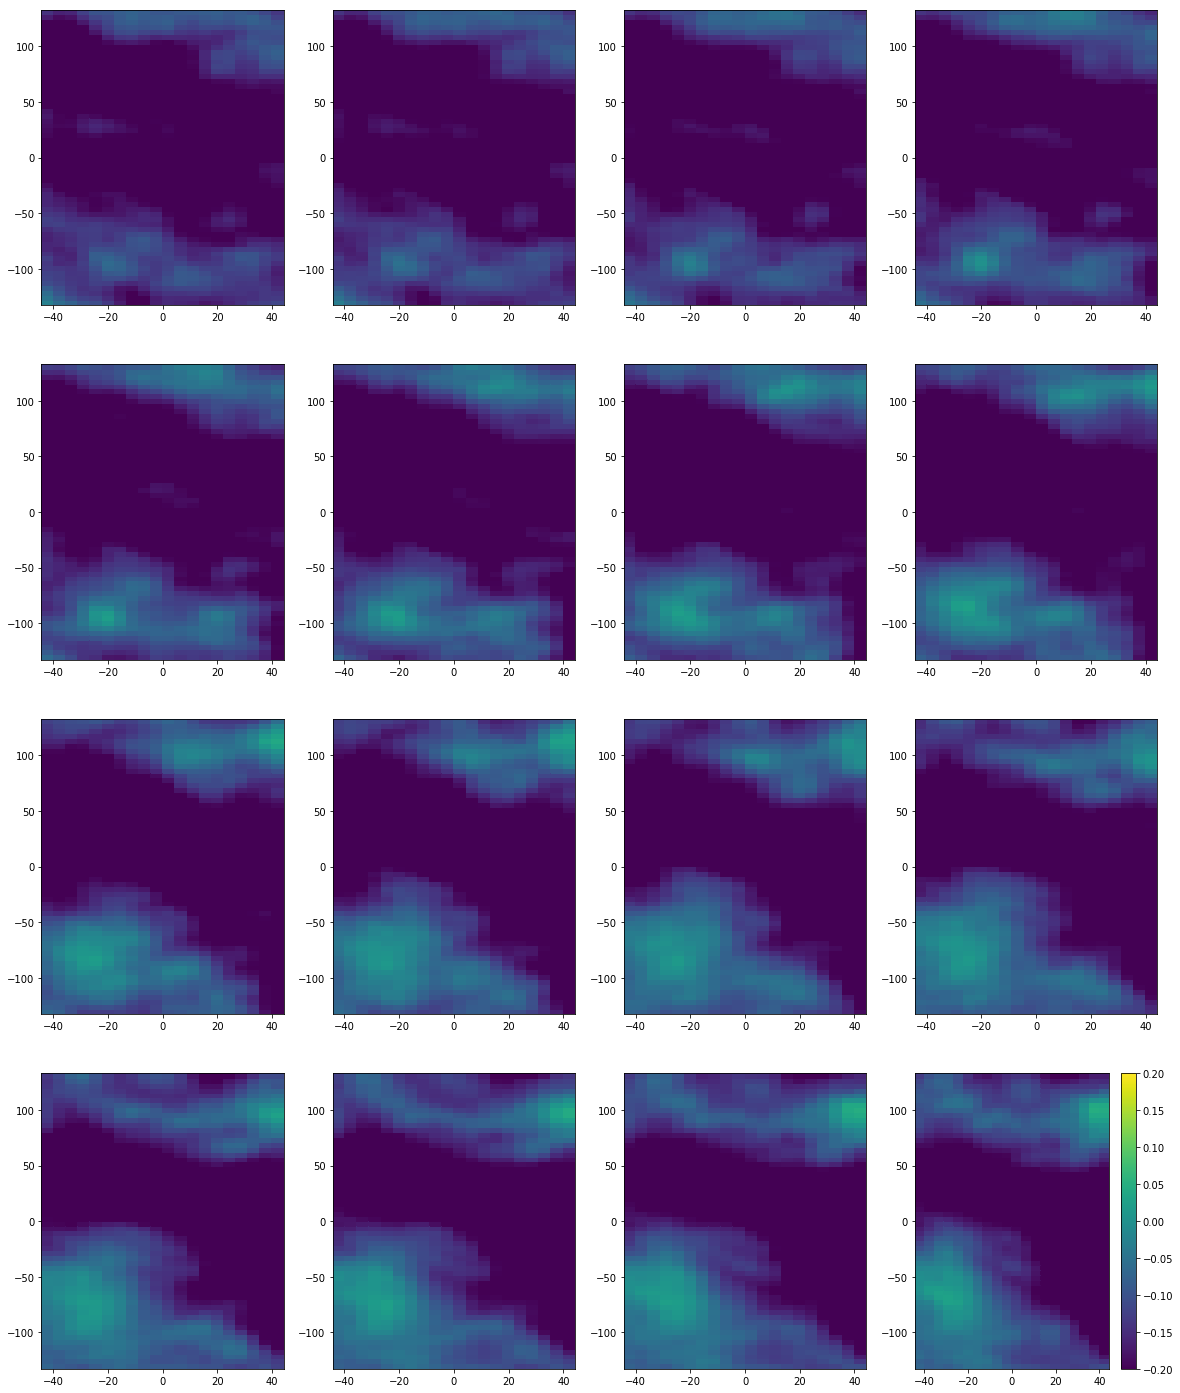

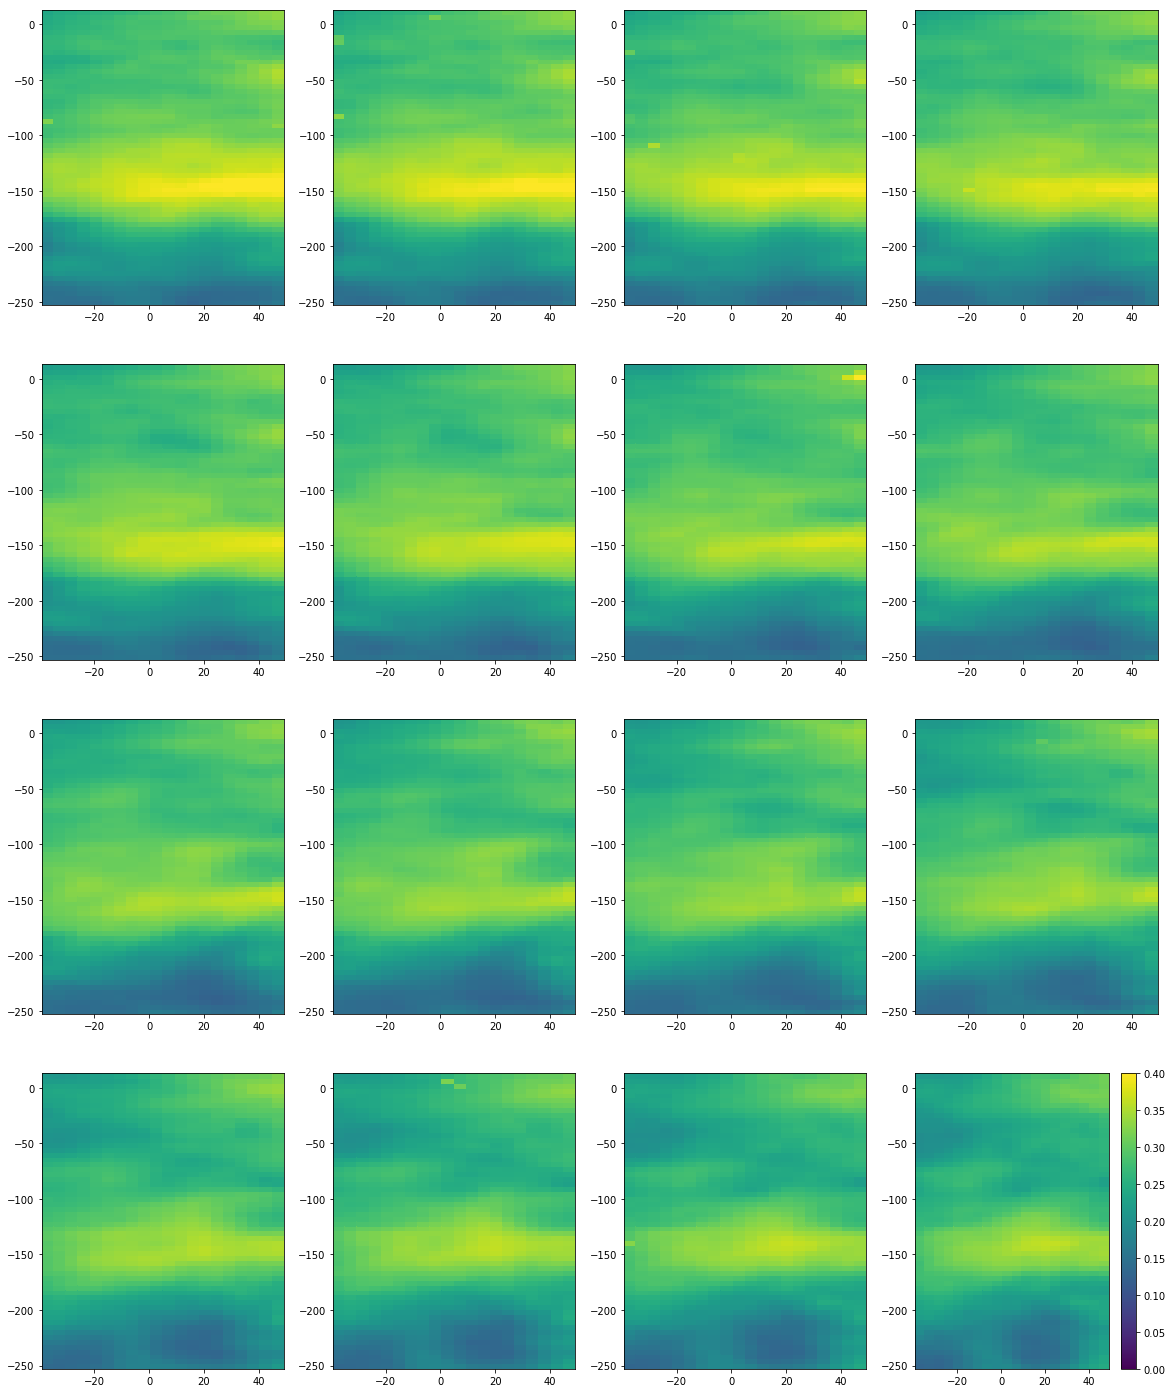

In [38]:
fig,axs=plt.subplots(4,4,figsize=(20,25))

for i in range(4):
    for j in range(4):
        plt.subplot(4,4,i*4+j+1)
        plt.pcolormesh(X[0,...],Y[0,...],u_rms[i*4+j,...],vmin=0,vmax=0.4)
#    plt.colorbar()
plt.colorbar()

In [67]:
M.PIV3D.m.keys()

dict_keys(['U', 'mean_flow', 'fluc', 'u_rms', 'overlap'])

In [69]:
f = h5pylea.file_name_in_dir(M, savefolder)
h5pylea.obj_in_h5py(M,f)
f.close()

[array([255,  25,  26, ...,  29,  26,  27], dtype=uint8), array([255,  24,  25, ...,  23,  27,  25], dtype=uint8), array([255,  26,  27, ...,  28,  22,  23], dtype=uint8), array([255,  28,  25, ...,  33,  28,  25], dtype=uint8), array([255,  24,  26, ...,  28,  26,  24], dtype=uint8), array([255,  26,  28, ...,  23,  29,  27], dtype=uint8), array([255,  25,  24, ...,  29,  29,  23], dtype=uint8), array([255,  27,  27, ...,  25,  24,  27], dtype=uint8), array([255,  23,  28, ...,  28,  26,  29], dtype=uint8), array([255,  26,  26, ...,  26,  25,  26], dtype=uint8), array([255,  29,  26, ...,  25,  28,  29], dtype=uint8), array([255,  25,  25, ...,  27,  31,  28], dtype=uint8), array([255,  30,  29, ...,  31,  28,  27], dtype=uint8), array([255,  25,  28, ...,  25,  28,  23], dtype=uint8), array([255,  31,  29, ...,  27,  27,  29], dtype=uint8), array([255,  28,  27, ...,  26,  25,  27], dtype=uint8), array([255,  29,  24, ...,  27,  25,  25], dtype=uint8), array([255,  28,  28, ...,  25

[[[[[-1.23468399e-01 -1.06401443e-01]
    [ 3.95240784e-02 -2.03538895e-01]
    [ 1.51737213e-01 -1.25419617e-01]
    ...
    [ 5.16777039e-02  8.68141174e-01]
    [ 2.80380249e-02  6.94602966e-01]
    [ 5.58815002e-02  5.65692902e-01]]

   [[-6.72740936e-02 -1.17200851e-01]
    [ 4.85572815e-02 -3.99684906e-01]
    [ 2.19211578e-01 -3.01610947e-01]
    ...
    [ 1.21402740e-01  7.60993958e-01]
    [ 2.39913940e-01  6.01291656e-01]
    [ 2.75512695e-01  5.19767761e-01]]

   [[-9.17797089e-02 -1.90555573e-01]
    [-2.36911774e-02 -3.10941696e-01]
    [ 7.01255798e-02 -2.53337860e-01]
    ...
    [ 3.23612213e-01  6.49780273e-01]
    [ 3.14365387e-01  5.59383392e-01]
    [ 3.23741913e-01  4.59690094e-01]]

   ...

   [[-4.25825119e-01 -2.08019257e-01]
    [-6.71878815e-01  4.08782959e-02]
    [-6.04597092e-01 -1.06828690e-01]
    ...
    [ 3.77655029e-02  3.37860107e-01]
    [ 2.19974518e-01  3.80722046e-01]
    [ 1.63330078e-01  3.36265564e-01]]

   [[-6.12697601e-01  1.77349091e-01]
  

[[[[-0.02675269 -0.10646099]
   [-0.04478481 -0.10135211]
   [-0.05989137 -0.08555783]
   ...
   [-0.16806282  0.14311389]
   [-0.14322272  0.17489689]
   [-0.14214122  0.21995512]]

  [[-0.05788217 -0.1057163 ]
   [-0.07791303 -0.09698423]
   [-0.0947848  -0.07901198]
   ...
   [-0.19028767  0.1233019 ]
   [-0.1637043   0.16556521]
   [-0.1507357   0.20636191]]

  [[-0.07638228 -0.11603426]
   [-0.10448593 -0.11088682]
   [-0.12078953 -0.09316258]
   ...
   [-0.18171039  0.1064449 ]
   [-0.15907601  0.14388067]
   [-0.14087545  0.17736957]]

  ...

  [[-0.12536987 -0.20275277]
   [-0.13439438 -0.21270169]
   [-0.1347478  -0.2050672 ]
   ...
   [-0.0935217   0.15529515]
   [-0.11442229  0.15942385]
   [-0.12315982  0.13325905]]

  [[-0.11599506 -0.18170995]
   [-0.13159336 -0.19200352]
   [-0.13856496 -0.19481811]
   ...
   [-0.12288642  0.17810258]
   [-0.13688168  0.1816379 ]
   [-0.14026797  0.15888148]]

  [[-0.13213821 -0.15919104]
   [-0.14299307 -0.17226408]
   [-0.15489936 -0.1

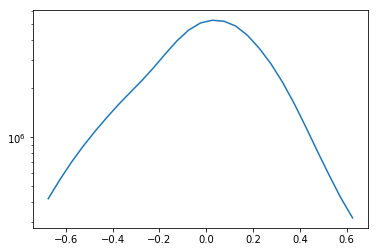

In [70]:
V = fluc[...,0]
[n,x] = np.histogram(np.ndarray.flatten(V),np.arange(-0.7,0.7,0.05))
x = (x[1:]+x[:-1])/2
plt.semilogy(x,n)

In [68]:
fluc.shape

(3150, 16, 21, 61, 2)

In [75]:
M.data.param.fx = float(M.data.param.fx)

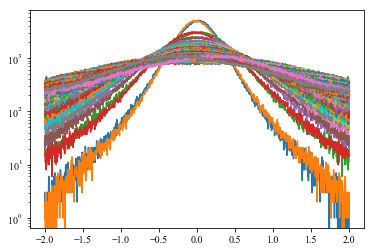

In [119]:
i=1
a = 50
blist = np.arange(i,a)
V2 = []
V3 = []

j = 15
stdfluc = np.std(fluc[:,j,:,a:,0])

for b in blist:
    V = (fluc[:,j,:,a:,0]-fluc[:,j,:,a-b:-b,0])/stdfluc
    V = V# - np.mean(V)
    [n,x] = np.histogram(np.ndarray.flatten(V),1000,[-2,2])
    x = (x[1:]+x[:-1])/2
    plt.semilogy(x,n)
    plt.semilogy(-x,n)
    
    V2.append(np.nanmean(V**2))
    V3.append(np.nanmean(V**3))
    
    
V2 = np.asarray(V2)
V3 = np.asarray(V3)

In [104]:
blist = np.arange(1,a)
blist = blist*piv.m['overlap']*M.data.param.fx
blist

array([ 4.432,  8.864, 13.296, 17.728, 22.16 , 26.592, 31.024, 35.456,
       39.888, 44.32 ])

In [162]:
m.PIV3D.m.keys()

dict_keys(['U', 'mean_flow', 'fluc', 'u_rms'])

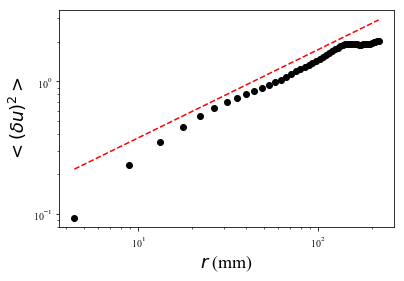

In [120]:
blist = np.arange(1,a)
blist = blist*piv.m['overlap']*M.data.param.fx
plt.loglog(blist,V2,'ko')

b0 = 4.5
alpha = 2./3

plt.loglog(blist,0.22*(blist/b0)**alpha,'r--')
#plt.axis([0,150,1,100])

fig = graphes.legende('$r$ (mm)','$<(\delta u)^2>$','')

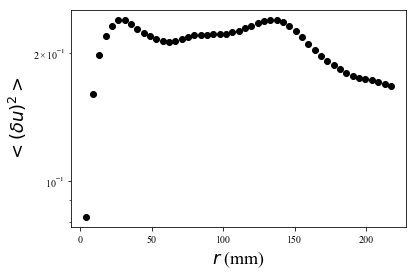

In [121]:
blist = np.arange(1,a)
blist = blist*piv.m['overlap']*M.data.param.fx
plt.semilogy(blist,10**3*(V2/2*stdfluc**2)**(3/2)/blist,'ko')

b0 = 4.5
alpha = 2./3

#plt.loglog(blist,0.25*(blist/b0)**alpha,'r--')
#plt.axis([0,150,1,100])

fig = graphes.legende('$r$ (mm)','$<(\delta u)^2>$','')

In [117]:
epsilon = 0.005

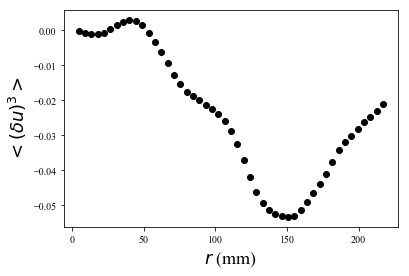

In [122]:
plt.plot(blist,V3*stdfluc**3,'ko')

b0 = 4.5
alpha = 2./3

#plt.plot(blist,-blist*4/5*epsilon*10**-3)
#plt.loglog(blist,0.25*(blist/b0)**alpha,'r--')
#plt.axis([0,40,-0.1,0.2])

fig = graphes.legende('$r$ (mm)','$<(\delta u)^3>$','')

In [172]:
piv.m['overlap']
m.data.param.fx

'0.277'

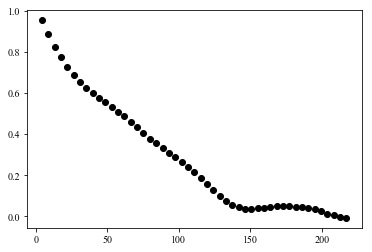

In [123]:
#blist = np.arange(1,50)
#blist = blist*overlap*fx
plt.plot(blist,1-V2/2,'ko')

b0 = 10
alpha = -0.5
#plt.loglog(blist,0.5*(blist/b0)**alpha,'r--')
#plt.axis([1,200,0.1,1])
#plt.axis([0,25,0,0.3])
#    plt.semilogy(-x,n,'r')

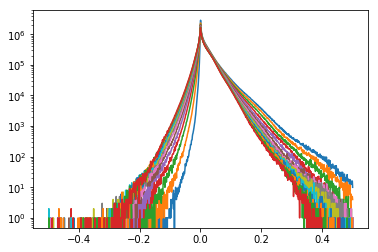

In [95]:
for b in range(1,15):
    V = fluc[...,30:,0]*fluc[...,30-b:-b,0]
    [n,x] = np.histogram(np.ndarray.flatten(V),1000,[-0.5,0.5])
    x = (x[1:]+x[:-1])/2
    plt.semilogy(x,n)
#    plt.semilogy(-x,n,'r')

In [92]:
Eku = np.abs(np.fft.fftshift(np.fft.fftn(fluc[...,0]**2,axes=(1,2,3)),axes=(1,2,3)))
Ekw = np.abs(np.fft.fftshift(np.fft.fftn(fluc[...,1]**2,axes=(1,2,3)),axes=(1,2,3)))

(16, 21, 61)
[15.649868627581101, 16.293154060324554, 17.221711633152143, 14.135945844126654, 16.427019369259042, 16.519511048551095, 14.81452031051697, 13.874664217727764, 10.595150305334496, 14.904906775056094, 10.756860905928434, 13.571739132234525, 9.634692890656929, 10.873631326992594, 12.753843786235691, 10.623900016446072, 9.387418356843735, 9.594903836338121, 10.042201367164887, 9.40942584575529, 7.693383120571897, 9.637016349913132, 9.986715317605436, 8.070531254678379, 8.449281181381542, 8.264908188141748, 7.463915483680387, 7.004733425947119, 8.234718414576129, 7.796859864659626, 7.187623079925772, 7.588487425860134, 6.632905419990437, 6.445098042676076, 6.675701462419035, 5.964259142757044, 6.250707174716402, 5.737830955973793, 5.641450778270699, 5.938333175438102, 5.560343693958164, 5.256009277584424, 5.4031696238588625, 5.139817300248224, 5.169547655479568, 4.622161683853426, 5.011316026240275, 4.368495256173741, 4.714245575337705, 3.9460458296845067, 4.501517020207098, 3

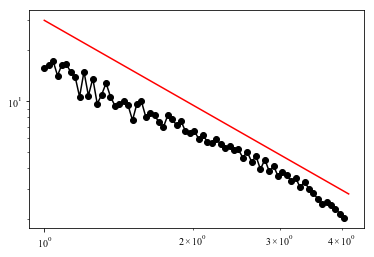

In [94]:
(Nt,Nz,Nx,Ny) = Eku.shape

fx = M.PIV3D.data.param.fx
overlap = piv.m['overlap']
dx = fx*overlap
fx = 0.277
k0x = 1/(2*dx)
k0z = 1/(2*dz)

kx = k0x*np.linspace(-Nx//2,Nx//2,Nx)
ky = k0x*np.linspace(-Ny//2,Ny//2,Ny)
kz = k0z*np.linspace(-Nz//2,Nz//2,Nz)

[Kx,Kz,Ky] = np.meshgrid(kx,kz,ky)
print(Kx.shape)

K = np.sqrt(Kx**2 + Ky**2 + Kz**2)

Klist = np.logspace(0,np.log10(np.max(K)),70)
E1d = []
for i,k0 in enumerate(Klist[:-1]):
    indices = np.logical_and(K>=Klist[i],K<Klist[i+1])
    #print(Ek[250,indices])
    val = np.nanmean(Ekw[:,indices])#*(Klist[i+1]-Klist[i])#*Klist[i]**2
    E1d.append(val)

print(E1d)
plt.loglog(Klist[:-1],E1d,'ko-')
plt.loglog(Klist,30*Klist**(-5./3),'r-')

In [158]:
10**-1.7

0.0199526231496888

dx : 
0.000277
dt_ab: 
0.001


In [27]:
ff.shape

(126000, 23, 63, 2)

(3150, 16, 23, 63, 2)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


24


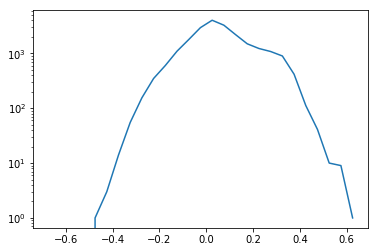

In [131]:
def display_correlation(t,C,DT=250):
    plt.subplot(1,3,1)
    plt.plot(t,C)
    plt.axis([-DT,DT,-0.2,1.05])
    graphes.legende('Time (ms)','$<u(t)u(t+\Delta t) >_{x,y,z}$','')

    plt.subplot(1,3,2)
    plt.plot(t,C)
    plt.axis([-DT/5,DT/5,0.75,1.05])
    graphes.legende('Time (ms)','','')

    plt.subplot(1,3,3)
    plt.plot(t,C)
    plt.axis([-DT/20,DT/20,0.9,1.01])
    graphes.legende('Time (ms)','','')

Total number of frames processed : 220
Volume with less than 5% error : 130


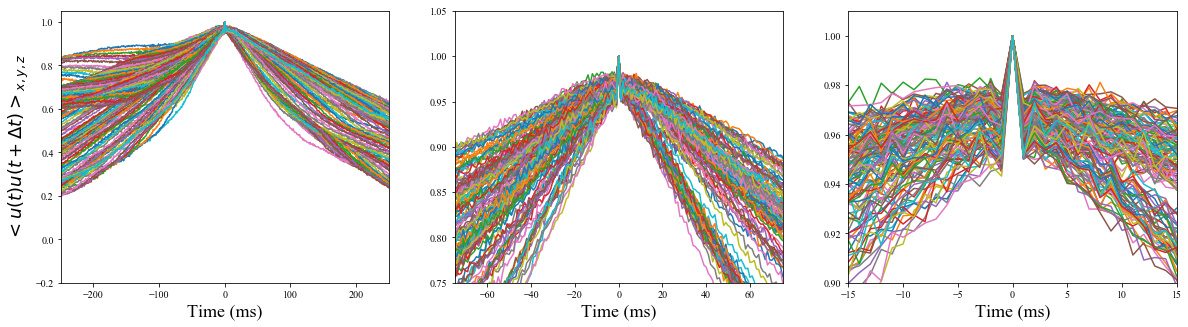

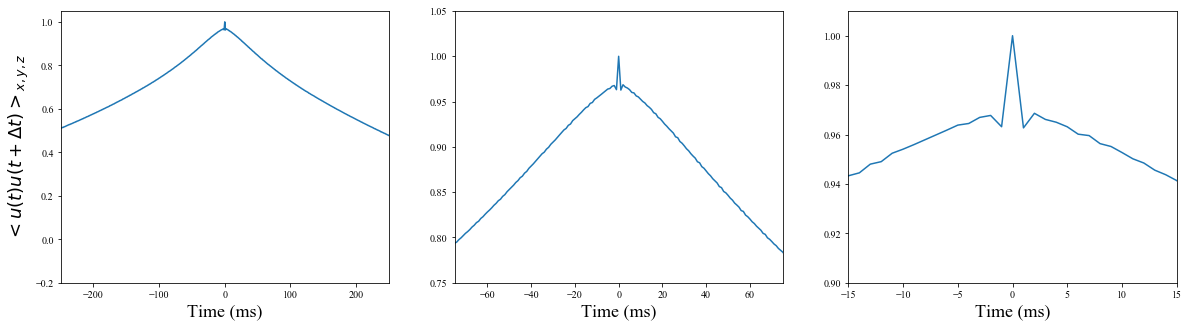

In [129]:
fig,axs=plt.subplots(1,3,figsize=(20,5))

good_frame = []
Ct = []
error = []
DT = 400
tlist = range(DT,3000-DT,10)
print("Total number of frames processed : "+str(len(tlist)))

for t0 in tlist:
    ff2 = np.nanmean(fluc[t0,...,0]**2,axis=(0,1,2))
    C = []
    t = np.arange(t0-DT,t0+DT,1)
    
    C0 = np.nanmean(fluc[t0+1,...,0]*fluc[t0,...,0],axis=(0,1,2))/ff2
    error.append(1-C0)
    if C0>0.95:  
        for tc in t:
#    print(tc)
            C0 = np.nanmean(fluc[tc,...,0]*fluc[t0,...,0],axis=(0,1,2))/ff2
            C.append(C0) 
        display_correlation(t-t0,C)        
        Ct.append(C)
        good_frame.append(t0)
Ct = np.asarray(Ct)

print("Volume with less than 5% error : "+str(Ct.shape[0]))
Ctmean = np.nanmean(Ct,axis=0)
tmean = t-t0

fig,axs=plt.subplots(1,3,figsize=(20,5))
display_correlation(tmean,Ctmean)

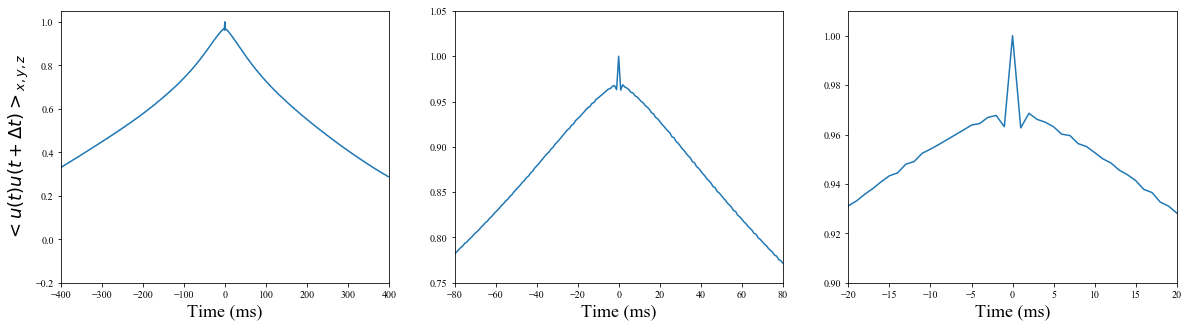

In [132]:
fig,axs=plt.subplots(1,3,figsize=(20,5))
display_correlation(tmean,Ctmean,DT=400)

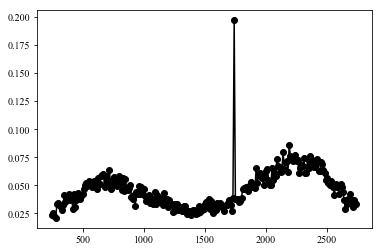

In [127]:
plt.plot(tlist,error,'ko-')
#plt.axis([1500,1600,0,0.8])

In [211]:
print(fluc.shape)

(2999, 40, 23, 63, 2)


Correlation time (ms) : 116 ms


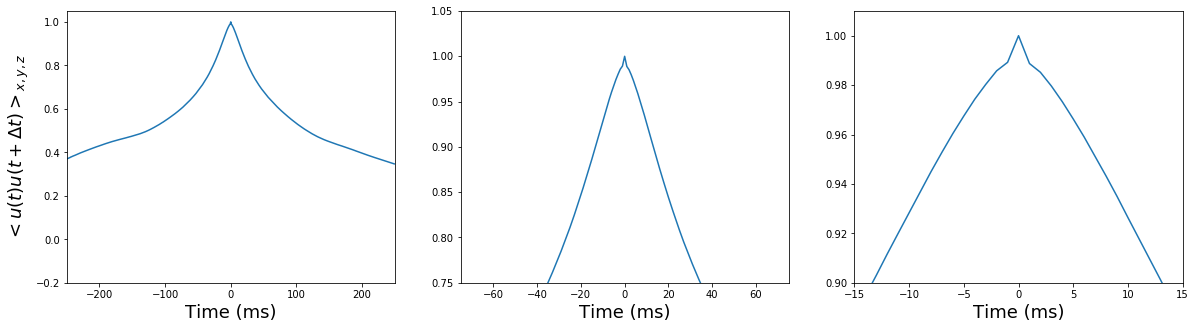

In [65]:
fig,axs=plt.subplots(1,3,figsize=(20,5))
display_correlation(tmean,Ctmean)

i = np.argmin(np.abs(Ctmean-0.5))
print('Correlation time (ms) : '+str(np.abs(tmean[i])) +' ms')

In [341]:
1024/384
41/17

2.411764705882353

In [66]:
#generate axis
(Nz,Nx,Ny,Nc) = mean_flow.shape
#mean_flow = np.transpose(mean_flow,(1,2,0,3))

dz = 42/20
x = np.arange(-(Nx-1)/2,(Nx-1)/2+1)*processing.dx*1E3*overlap+5
y = np.arange(-(Ny-1)/2,(Ny-1)/2+1)*processing.dx*1E3*overlap-120
z = np.arange(-Nz/2,Nz/2)*dz-2

#invariance by rotation in the plane (x,z)

[X,Z,Y] = np.meshgrid(x,z,y)
print(X.shape)

(16, 21, 61)


In [52]:
Xv = X[:,:-1,:-1]
Yv = Y[:,:-1,:-1]
Zv = Z[:,:-1,:-1]

flucv = fluc[...,:-1,:-1,:]

(Nz,Nx,Ny) = Xv.shape
(k0,i0,j0) = tuple(np.asarray(Xv.shape)//2)

#j0 = 4
print(Xv.shape)

x0 = Xv[k0,i0,j0]
y0 = Yv[k0,i0,j0]
z0 = Zv[k0,i0,j0]

R = np.sqrt((Xv-x0)**2+(Yv-y0)**2+(Zv-z0)**2)

ff2u = np.nanmean(flucv[:,k0,i0,j0,0]**2)
ff2v = np.nanmean(flucv[:,k0,i0,j0,1]**2)

Cmapu = flucv[...,0]*np.transpose(np.tile(flucv[:,k0,i0,j0,0],(Nz,Nx,Ny,1)),(3,0,1,2))
Cmapv = flucv[...,1]*np.transpose(np.tile(flucv[:,k0,i0,j0,1],(Nz,Nx,Ny,1)),(3,0,1,2))

print(Cmapu.shape)

(16, 22, 62)
(3150, 16, 22, 62)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


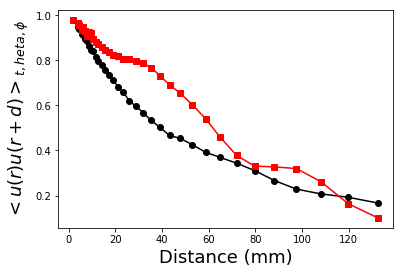

In [40]:
dlist = np.logspace(0,np.log10(np.max(R)),50)

Cdu = []
Cdv = []
for i,d in enumerate(dlist[:-1]):
    indices = np.logical_and(R>=dlist[i],R<dlist[i+1])
    #print(np.sum(indices))
    C0u = np.nanmean(Cmapu[:,indices])/ff2u
    C0v = np.nanmean(Cmapv[:,indices])/ff2v

    Cdu.append(C0u)
    Cdv.append(C0v)
    
plt.plot(dlist[:-1],Cdu,'ko-')
plt.plot(dlist[:-1],Cdv,'rs-')

fig = graphes.legende('Distance (mm)','$<u(r)u(r+d) >_{t,\theta,\phi}$','')

(16, 22, 62)
(1062, 16, 22, 62)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/usr/lib/python3/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice


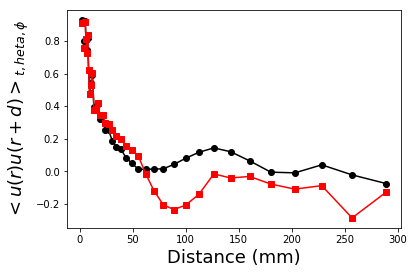

In [260]:
Xv = X[2:18,:-1,:-1]
Yv = Y[2:18,:-1,:-1]
Zv = Z[2:18,:-1,:-1]

flucv = fluc[:,2:18,:-1,:-1,:]

(Nz,Nx,Ny) = Xv.shape
(k0,i0,j0) = tuple(np.asarray(Xv.shape)//2)

j0 = 4
print(Xv.shape)

x0 = Xv[k0,i0,j0]
y0 = Yv[k0,i0,j0]
z0 = Zv[k0,i0,j0]

R = np.sqrt((Xv-x0)**2+(Yv-y0)**2+(Zv-z0)**2)

ff2u = np.nanmean(flucv[good_frame,k0,i0,j0,0]**2)
ff2v = np.nanmean(flucv[good_frame,k0,i0,j0,1]**2)

Cmapu = flucv[good_frame,...,0]*np.transpose(np.tile(flucv[good_frame,k0,i0,j0,0],(Nz,Nx,Ny,1)),(3,0,1,2))
Cmapv = flucv[good_frame,...,1]*np.transpose(np.tile(flucv[good_frame,k0,i0,j0,1],(Nz,Nx,Ny,1)),(3,0,1,2))

print(Cmapu.shape)
dlist = np.logspace(0,np.log10(np.max(R)),50)

Cdu = []
Cdv = []
for i,d in enumerate(dlist[:-1]):
    indices = np.logical_and(R>=dlist[i],R<dlist[i+1])
    #print(np.sum(indices))
    C0u = np.nanmean(Cmapu[:,indices])/ff2u
    C0v = np.nanmean(Cmapv[:,indices])/ff2v

    Cdu.append(C0u)
    Cdv.append(C0v)
    
plt.plot(dlist[:-1],Cdu,'ko-')
plt.plot(dlist[:-1],Cdv,'rs-')

fig = graphes.legende('Distance (mm)','$<u(r)u(r+d) >_{t,\theta,\phi}$','')

In [67]:
Xv = X[:,:-1,:-1]
Yv = Y[:,:-1,:-1]
Zv = Z[:,:-1,:-1]

flucv = fluc[...,:-1,:-1,:]

(Nz,Nx,Ny) = Xv.shape
(k0,i0,j0) = tuple(np.asarray(Xv.shape)//2)

j0 = 60
#i0 = 20

x0 = Xv[k0,i0,j0]
y0 = Yv[k0,i0,j0]
z0 = Zv[k0,i0,j0]

[R,Theta] = Smath.cart2pol(Xv-x0,Yv-y0)
#R = np.sqrt((Xv-x0)**2+(Yv-y0)**2)


ff2u = np.nanmean(flucv[...,i0,j0,0]**2)
ff2v = np.nanmean(flucv[...,i0,j0,1]**2)

Cmapu = flucv[...,0]*np.transpose(np.tile(flucv[...,i0,j0,0],(Nx,Ny,1,1)),(2,3,0,1))
Cmapv = flucv[...,1]*np.transpose(np.tile(flucv[...,i0,j0,1],(Nx,Ny,1,1)),(2,3,0,1))

print(Cmapu.shape)
dlist = np.logspace(np.log10(1),np.log10(np.max(R)),50)

Cdu = []
Cdv = []
Cd = []
for i,d in enumerate(dlist[:-1]):
    indices = np.logical_and(R>=dlist[i],R<dlist[i+1])
    #print(np.sum(indices))
    C0u = np.nanmean(Cmapu[...,indices])
    C0v = np.nanmean(Cmapv[...,indices])
    
    Cd.append((C0u+C0v)/(ff2u+ff2v))
#    C0l = 
#    C0t = 
    Cdu.append(C0u/ff2u)
    Cdv.append(C0v/ff2v)

fig,axs=plt.subplots(1,2,figsize=(20,7))
plt.subplot(1,2,1)
plt.plot(dlist[:-1],Cd,'bo-')
plt.plot(dlist[:-1],Cdu,'ko-')
plt.plot(dlist[:-1],Cdv,'rs-')
plt.axis([0,50,0,1])
fig = graphes.legende('Distance (mm)','$<u(r)u(r+d) >_{t,\theta,\phi}$','')
                  
plt.subplot(1,2,2)
plt.plot(dlist[:-1],Cd,'bo-')
plt.plot(dlist[:-1],Cdu,'ko-')
plt.plot(dlist[:-1],Cdv,'rs-')
plt.plot(dlist,np.zeros(len(dlist)),'k--')
plt.axis([0,300,-0.5,1])
fig = graphes.legende('Distance (mm)','','')

IndexError: index 60 is out of bounds for axis 2 with size 60

In [60]:
Ek = np.abs(np.fft.fftshift(np.fft.fftn(fluc[...,:-1,:-1,0]**2,axes=(1,2,3)),axes=(1,2,3)))

In [61]:
print(Ek.shape)
np.sum(np.isnan(np.ndarray.flatten(Ek)))

(3150, 16, 22, 62)


68745600

(16, 22, 62)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


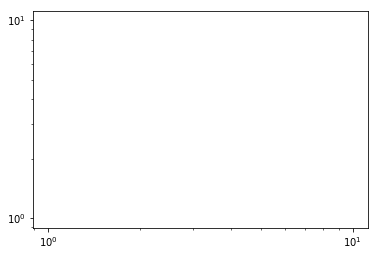

In [64]:
Ek = np.abs(np.fft.fftshift(np.fft.fftn(fluc[...,:-1,:-1,0]**2,axes=(1,2,3)),axes=(1,2,3)))

(Nt,Nz,Nx,Nt) = Ek.shape

kx = np.linspace(-Nx//2,Nx//2,Nx)
ky = np.linspace(-Ny//2,Ny//2,Ny)
kz = np.linspace(-Nz//2,Nz//2,Nz)

[Kx,Kz,Ky] = np.meshgrid(kx,kz,ky)
print(Kx.shape)

K = np.sqrt(Kx**2 + Ky**2 + Kz**2)

Klist = np.logspace(0,np.log10(np.max(K)),50)
E1d = []
for i,k0 in enumerate(Klist[:-1]):
    indices = np.logical_and(K>=Klist[i],K<Klist[i+1])
    #print(Ek[250,indices])
    val = np.nanmean(Ek[:,indices])
    E1d.append(val)

print(E1d)
plt.loglog(Klist[:-1],E1d,'ko-')
#plt.loglog(Klist,100*Klist**(-5./3),'r-')

In [266]:
a = np.ones((299,40))
np.transpose(np.tile(a,(23,63,1,1)),(2,3,0,1)).shape

(299, 40, 23, 63)

1475


[1200, 1750, -0.2, 1.05]

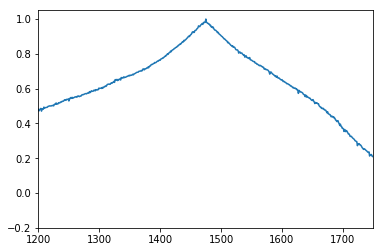

In [111]:
t = np.arange(0,2950,1)
n = len(t)
t0 = t[(n+1)//2]
print(t0)
ff2 = np.nanmean(fluc[t0,2:18,...,1]**2,axis=(0,1,2))
C = []
for tc in t:
#    print(tc)
    C.append(np.nanmean(fluc[tc,2:18,...,1]*fluc[t0,2:18,...,1],axis=(0,1,2))/ff2) 
plt.plot(t,C)
plt.axis([1200,1750,-0.2,1.05])

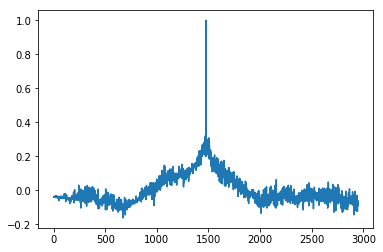

In [28]:
print(mean_flow.shape)
print(X[:,:,:].shape)

(40, 23, 63, 2)
(40, 23, 63)


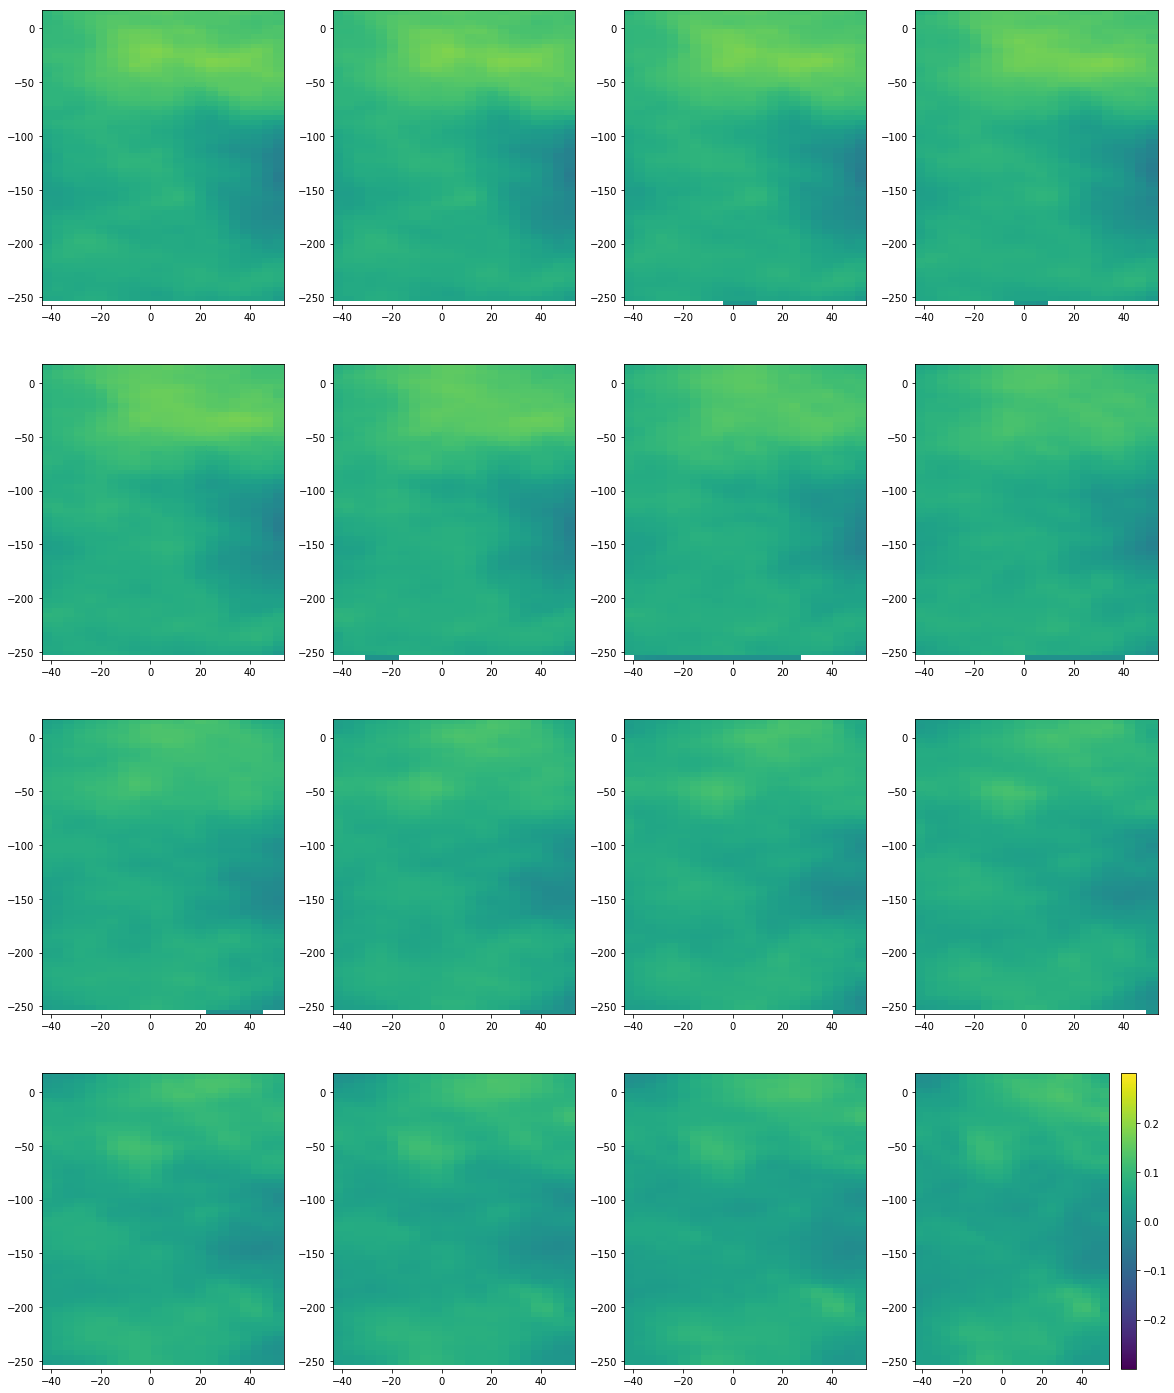

In [68]:
fig,axs=plt.subplots(4,4,figsize=(20,25))

for i in range(4):
    for j in range(4):
        plt.subplot(4,4,i*4+j+1)
        plt.pcolormesh(X[0,...],Y[0,...],mean_flow[i*4+j,...,0],vmin=-0.3,vmax=0.3)
#    plt.colorbar()
plt.colorbar()

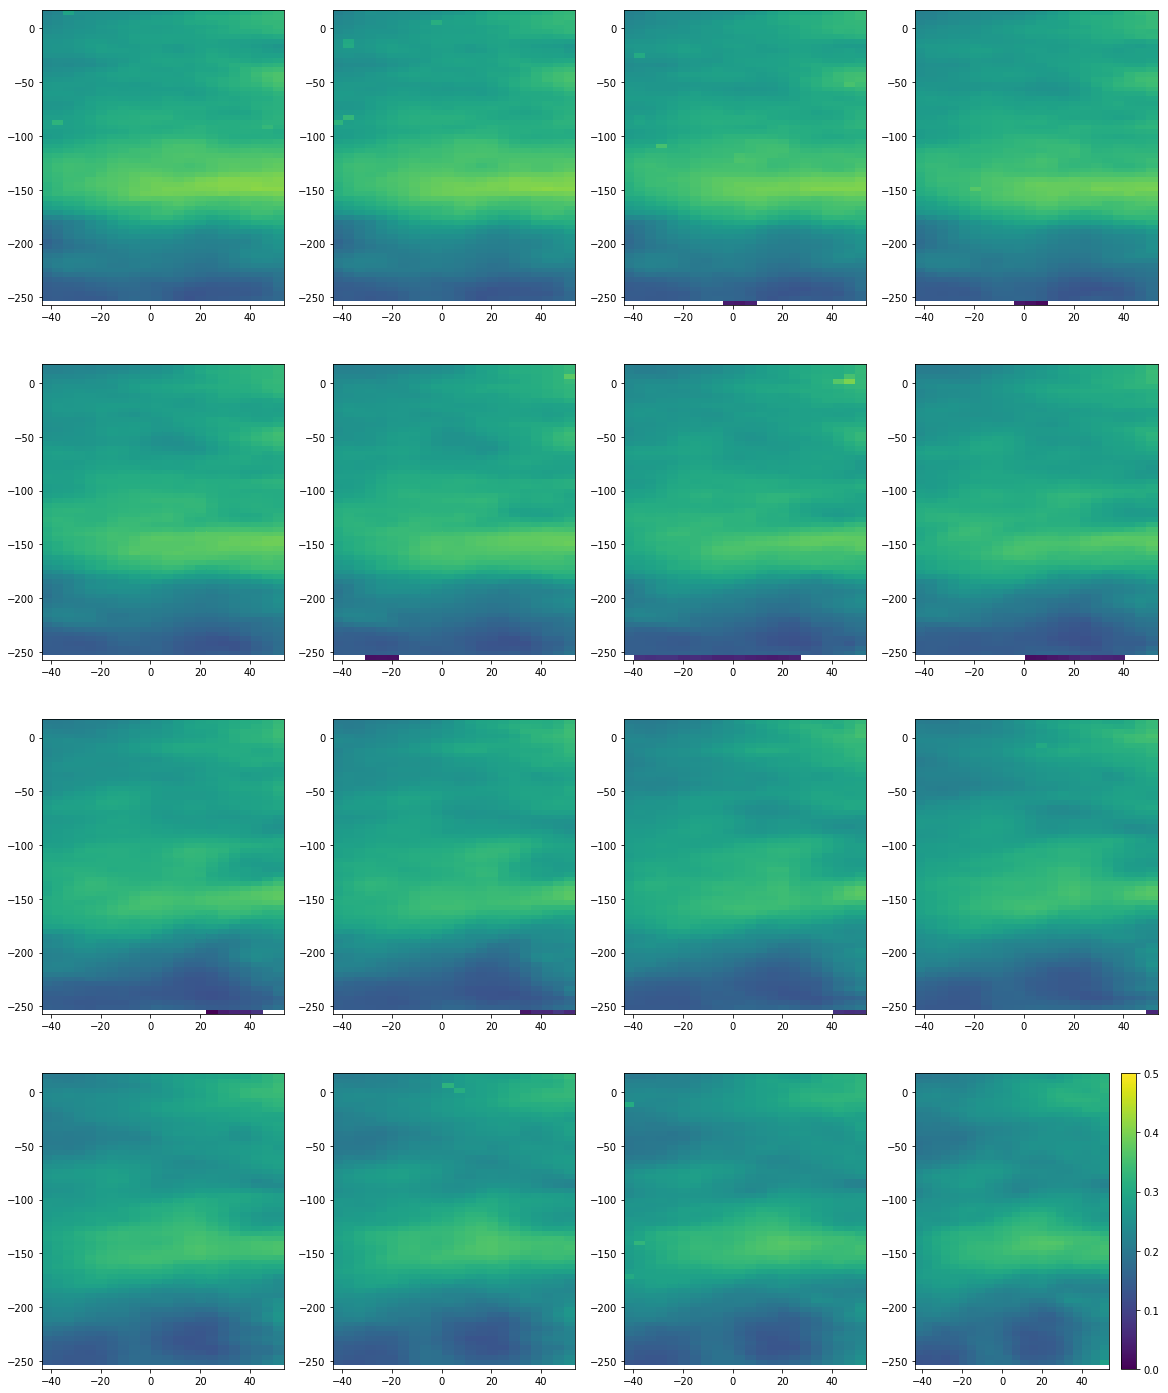

In [67]:
fig,axs=plt.subplots(4,4,figsize=(20,25))

for i in range(4):
    for j in range(4):
        plt.subplot(4,4,i*4+j+1)
        plt.pcolormesh(X[0,...],Y[0,...],u_rms[i*4+j,...],vmin=0,vmax=0.5)
plt.colorbar()

(23, 63)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


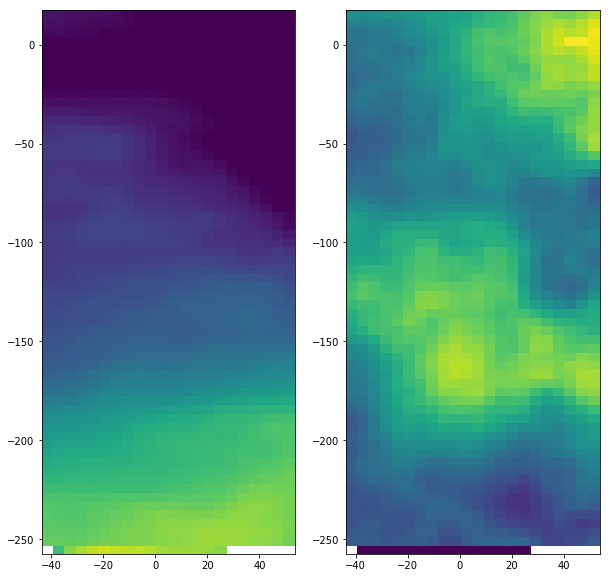

In [69]:
fig,axs=plt.subplots(1,2,figsize=(10,10))
print(mean_flow[10,...,0].shape)
axs[0].pcolormesh(X[0,...],Y[0,...],mean_flow[6,...,1],vmin=-0.3,vmax=0.3)
#plt.colorbar()

axs[1].pcolormesh(X[0,...],Y[0,...],np.nanmean(fluc[:,6,...,0]**2,axis=0),vmin=0,vmax=0.05)
#plt.colorbar()

In [338]:
[R,Theta] = Smath.cart2pol(X,Z)
Ur = 2*mean_flow[...,1]*np.cos(Theta)  #coefficient to be compensated by the circle fraction avalaible, so the coeff is r dependent
Utheta = -2*mean_flow[...,1]*np.sin(Theta) #average along Theta still required

fur = interp.RegularGridInterpolator((z,x,y),Ur,method='linear',bounds_error=False,fill_value=np.nan)
fut = interp.RegularGridInterpolator((z,x,y),Utheta,method='linear',bounds_error=False,fill_value=np.nan)
fuz = interp.RegularGridInterpolator((z,x,y),mean_flow[...,0],method='linear',bounds_error=False,fill_value=np.nan)

#futheta = interp.RegularGridInterpolator(Utheta, values, method='linear', bounds_error=True, fill_value=nan)[source]


In [248]:
print(Ur.shape)

(16, 31, 63)


In [242]:
helicity = fur((R[:,:,40]*np.cos(Theta[:,:,]),x[5],y[40]))

array([-0.073379  , -0.07342986, -0.06604033, -0.06482857, -0.06580828,
       -0.06344544, -0.05669815, -0.04911837, -0.03393364, -0.02424669,
       -0.01768416, -0.01310526, -0.00867227, -0.00059881,  0.00032977,
        0.00036066])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/usr/lib/python3/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/usr/lib/python3/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice


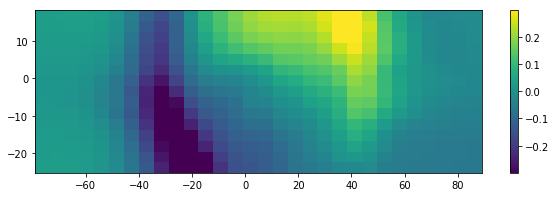

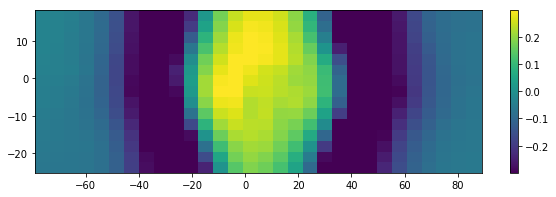

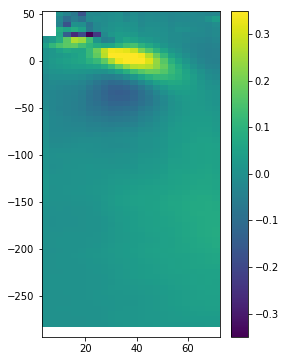

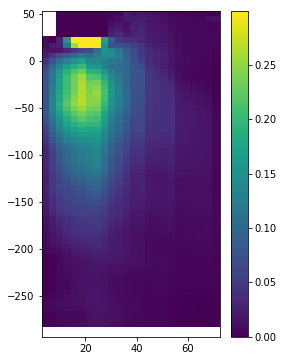

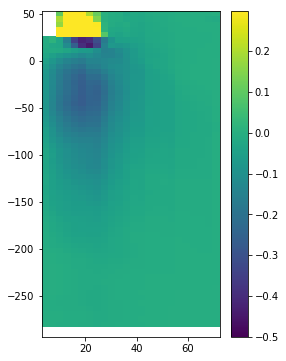

In [340]:
k =52

fig,axs=plt.subplots(1,1,figsize=(10,3))
plt.pcolormesh(X[...,0],Z[...,0],mean_flow[...,k,1],vmin=-0.3,vmax=0.3)
plt.colorbar()

fig,axs=plt.subplots(1,1,figsize=(10,3))
plt.pcolormesh(X[...,0],Z[...,0],mean_flow[...,k,0],vmin=-0.3,vmax=0.3)
plt.colorbar()



#fig,axs=plt.subplots(1,1,figsize=(10,3))
#plt.pcolormesh(X[...,0],Z[...,0],Ur[...,k],vmin=-0.3,vmax=0.3)
dtheta = 2*np.pi/50
theta = np.arange(np.pi/2,2*np.pi+np.pi/2,dtheta)
dr = dz
R0 = np.arange(dz,dz*(Nx-5),dz)
Nr = len(R0)

#plt.plot(np.min(R0)*np.cos(theta),np.min(R0)*np.sin(theta),'r')
#plt.plot(np.max(R0)*np.cos(theta),np.max(R0)*np.sin(theta),'r')

UR = np.zeros((Ny,Nr))
UT = np.zeros((Ny,Nr))
UZ = np.zeros((Ny,Nr))

for i in range(len(y)):
    for j,r0 in enumerate(R0):
        UR[i,j] = np.nanmean(fur((r0*np.cos(theta),r0*np.sin(theta),y[i])))
        UT[i,j] = np.nanmean(fut((r0*np.cos(theta),r0*np.sin(theta),y[i])))
        UZ[i,j] = np.nanmean(fut((r0*np.cos(theta),r0*np.sin(theta),y[i])))
    

fig,axs=plt.subplots(1,1,figsize=(4,6))
plt.pcolormesh(Rf,Yf,UR,vmin=-0.35,vmax=0.35)
plt.colorbar()


fig,axs=plt.subplots(1,1,figsize=(4,6))
plt.pcolormesh(Rf,Yf,-UT,vmin=0.,vmax=0.3)
plt.colorbar()

fig,axs=plt.subplots(1,1,figsize=(4,6))
plt.pcolormesh(Rf,Yf,UZ,vmin=-0.5,vmax=0.3)
plt.colorbar()

y
#fig,axs=plt.subplots(1,1,figsize=(10,3))
#plt.pcolormesh(X[...,0],Z[...,0],Utheta[...,k],vmin=-0.3,vmax=0.3)
#plt.colorbar()



#fig,axs=plt.subplots(1,1,figsize=(5,8))
#plt.pcolormesh(X[0,...],Y[0,...],mean_flow[6,...,1],vmin=-0.3,vmax=0.3)
#plt.colorbar()

In [192]:
#definition of mask
x0 = 175
y0 = 130
width = 120
height = 50

ValueError: cannot reshape array of size 31248 into shape (1,63)

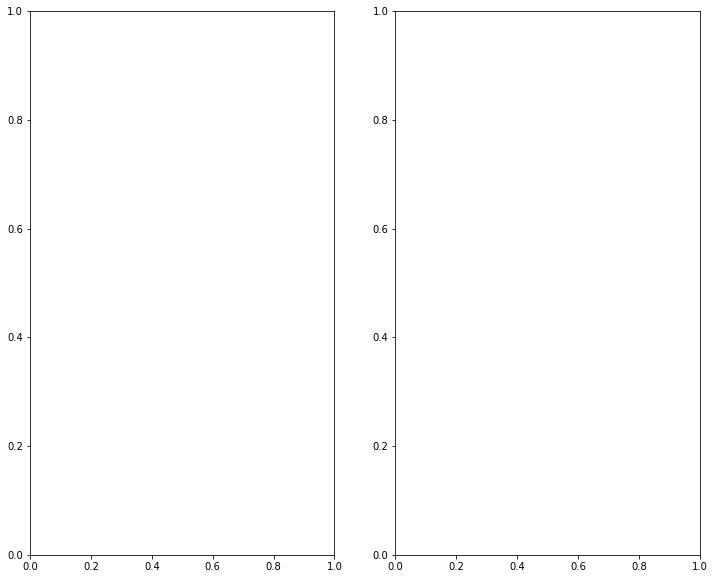

In [121]:
fig,axs=plt.subplots(1,2,figsize=(12,10)); axs=axs.flatten()
cax=[]
c=[]
j = 10
#for i in range(2):
#    divider = make_axes_locatable(axs[i])
#    cax.append(divider.append_axes('right', size='10%', pad=0.1))
    
for (i,data) in zip(range(2),[mean_speed[j,:,:],u_rms[j,:,:]]):
    #axs[i].clear()
    cb=axs[i].pcolormesh(X,Y,data,vmin=0,vmax=0.4)
#            cb=axs[i].pcolormesh(X,Y,ff[0,j,:,:,1],vmin=0,vmax=0.3)
#    fig.colorbar(cb)
#    c.append(fig.colorbar(cb, cax=cax[i], orientation='vertical'))

    axs[0].set_title(r'$y = '+str(int(z[j]))+' mm')
        #axs[1].set_title(r'$\bar u_{rms}$')

    axs[0].set_xlabel('$z$ (mm)')
    axs[i].set_xlabel('$x$ (mm)')
    #c[0].set_label(r'$\bar u$ (m/s)')
    #c[0].set_label(r'$\bar u_{rms}$ (m/s)')
    
    p=patches.Rectangle((x0,y0),width,height,facecolor='w',edgecolor='r')
    axs[i].add_patch(p)